## Content
* Data ingestion
    * Remove outliers
    * Remove adoption features not in ABM
    * Data splitting for CV
    * Define weights for weighted loss function
* Features preparation
    * Pipeline preparation
    * Features names collection
* Model selection
    * Functions for models results
    * Functions for models' error analyis
    * Models training
    * Results
* Final models tuning and training

In [1]:
import numpy as np
import pandas as pd
import math
import joblib
import os

In [2]:
import custom_transformers
from importlib import reload
reload(custom_transformers)

<module 'custom_transformers' from 'C:\\Users\\giaco\\sbp-adoption-abm-operational\\ml_models\\custom_transformers.py'>

In [3]:
from custom_transformers import (
    TransformAdoptionFeatures,
    TransformCensusFeatures, 
    TransformClimateFeatures,
    TransformSoilFeatures,
    TransformEconomicFeatures,
)

In [4]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
 # How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=10)

# Data ingestion

In [7]:
path_to_dataset = "Municipalities final dataset for analysis.csv"

In [8]:
dataset_original = pd.read_csv(path_to_dataset, index_col=['Municipality', 'Year'])

In [9]:
# Remove features with 0 adoption to obtain the regression dataset
mask_no_adoption = dataset_original['adoption_in_year'] < 0.0000001
dataset_original = dataset_original.drop(dataset_original.loc[mask_no_adoption].index)
len(dataset_original)

2518

In [10]:
# Remove outliers adoption_in_year
outliers = dataset_original.loc[dataset_original['adoption_in_year'] > 0.12].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([(    'Vagos', 2007),
            (    'Vagos', 2008),
            (    'Tomar', 2005),
            ('Alcochete', 2010),
            ('Alcochete', 2011),
            ('Alcochete', 2012)],
           names=['Municipality', 'Year'])


In [11]:
# Remove outliers cumul_adoption_10_y_pr_y_munic
outliers = dataset_original.loc[dataset_original['tot_cumul_adoption_pr_y_munic'] > 0.4].index
dataset_original = dataset_original.drop(outliers)
print(outliers)

MultiIndex([('Tomar', 2003),
            ('Tomar', 2004),
            ('Tomar', 2006),
            ('Tomar', 2007),
            ('Tomar', 2008)],
           names=['Municipality', 'Year'])


In [12]:
dataset_original.shape

(2507, 45)

In [13]:
dataset = dataset_original.reset_index(drop=True)

### Create a mapping of each new instance to municipality and year it's referring to

In [14]:
map_instances_to_munic_year = dict(zip(dataset.index, dataset_original.index))

## Final number of instances and features

In [15]:
dataset.shape

(2507, 45)

## Copy the data splitting label and features

In [16]:
dataset_labels = dataset['adoption_in_year'].copy()
dataset = dataset.drop('adoption_in_year', axis=1)

In [17]:
dataset_labels.describe()

count   2507.000000
mean       0.004588
std        0.008447
min        0.000009
25%        0.000873
50%        0.002035
75%        0.004764
max        0.100604
Name: adoption_in_year, dtype: float64

## Split for cross-validation

Split used in all the cross-validation, stratified based on the number of data points before the PCF project and during it

In [18]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit

First, generate the feature to split, the year of the instance

In [19]:
dataset_split = dataset_original.copy()

In [20]:
years = dataset_split.index.get_level_values(1).to_list()
dataset_split['Year'] = years

Second, get for each instance the test fold it has to belong to based on the split based on the created category

In [21]:
n_folds = 3
strat_split = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [22]:
test_indexes = np.zeros(len(dataset_split))
fold = 0
for _, test_index in strat_split.split(dataset_split, dataset_split['Year']):
    for i in test_index:
        test_indexes[i] = fold
    fold += 1

Third, pass to the list of test folds indexes to generate the PredefinedSplit

In [23]:
cv_split = PredefinedSplit(test_indexes)

In [24]:
# Check ratio is kept
ratio_PCF_dataset = len(dataset_split.loc[(slice(None), [2007]), :]) / len(dataset_split)
test_set = dataset_split.iloc[np.where(test_indexes==1)]
ratio_PCF_test_set = len(test_set.loc[(slice(None), [2007]), :]) / len(test_set)
print(ratio_PCF_dataset, ratio_PCF_test_set)

0.0745911447945752 0.07416267942583732


### Define weights for weighted loss function
To give more weight to observations during the PCF years, of which we are more sure

In [243]:
weights_PCF_years = 3
years_PCF = [2009, 2010, 2011, 2012]

In [244]:
weights = np.ones(dataset.shape[0])

In [245]:
weights = [weights_PCF_years if dp in years_PCF else 1 for dp in dataset_original.index.get_level_values('Year')]

# Features preparation

## Features names collection

### Pre-transformation

In [25]:
features_original = [feat for feat in dataset.columns]

In [26]:
features_adoption = [feat for feat in features_original if 'adoption' in feat]
features_climate = [feat for feat in features_original if '_t_' in feat or '_prec_' in feat]
features_soil = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features_economic = ['sbp_payment']

features_not_census = (features_adoption + features_climate + features_soil + features_economic)
features_census = [feat for feat in features_original if feat not in features_not_census]

In [27]:
len(features_census) + len(features_not_census)

44

### Post-transformation

In [28]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(), TransformCensusFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features = features + features_ind

In [29]:
len(features)

19

#### With squared cumulative adoption

In [30]:
# Get features names
feat_lists = [features_adoption, features_census, features_climate, features_soil, features_economic]
transformers = [TransformAdoptionFeatures(add_square_cumul_adoption=True),
                TransformCensusFeatures(), TransformClimateFeatures(), TransformSoilFeatures(), TransformEconomicFeatures()]

features_sq = []
for f, t in zip(feat_lists, transformers):
    features_ind = t.transform(dataset[f]).columns.to_list()
    features_sq = features_sq + features_ind

In [31]:
len(features_sq)

20

## Preparation pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [33]:
transformation_pipeline = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(), features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

dataset_transf = transformation_pipeline.fit_transform(dataset)

In [34]:
full_pipeline_stand = Pipeline([
    ('transformation', transformation_pipeline),
    ('scaling', StandardScaler())
])

In [35]:
dataset_prepared_stand = full_pipeline_stand.fit_transform(dataset)

In [36]:
dataset_prepared_stand.shape

(2507, 19)

In [37]:
# Print prepared data as a DataFrame
pd.DataFrame(dataset_prepared_stand, columns=features, index=dataset.index).head()

,tot_cumul_adoption_pr_y_munic,tot_cumul_adoption_pr_y_port,pastures_area_var,pastures_area_mean,educ_second_super,farmers_over65,inc_mainly_ext,educ_none,work_unit_100ha,agric_area_owned,lu_per_agric_area,av_d_mean_t_average_munic,av_d_max_t_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,sbp_payment
0,-0.548656,-1.110309,-0.465921,-0.547095,-1.148383,-1.873076,-0.165081,0.594392,1.886435,-1.110286,0.510506,-1.190264,-0.960601,-1.022170,-0.492540,1.338014,1.526284,0.169302,-0.303171
1,-0.523279,-1.049231,-0.444689,-0.543765,-1.135353,-1.818875,-0.117406,0.413319,1.802742,-1.075636,0.505387,-1.190264,-0.960601,-1.022170,-0.492540,1.338014,1.526284,0.169302,-0.303171
2,-0.502132,-0.802274,-0.402226,-0.536066,-1.109293,-1.693575,-0.017736,0.051173,1.635355,-1.003198,0.495147,-1.190264,-0.960601,-1.022170,-0.492540,1.338014,1.526284,0.169302,-0.303171
3,-0.489444,-0.513078,-0.329192,-0.525116,-1.044338,-1.538859,-0.005124,-0.122476,1.366655,-0.654917,0.401709,-1.190264,-0.960601,-1.022170,-0.492540,1.338014,1.526284,0.169302,-0.303171
4,-0.447149,-0.267982,-0.292676,-0.519027,-1.011860,-1.452815,0.000985,-0.209301,1.232305,-0.486196,0.354990,-1.190264,-0.960601,-1.022170,-0.492540,1.338014,1.526284,0.169302,-0.303171


### With squared cumulative adoption

In [38]:
transformation_pipeline_sq = ColumnTransformer([
    ('adoption', TransformAdoptionFeatures(add_square_cumul_adoption=True),
     features_adoption),
    ('census', TransformCensusFeatures(), features_census),
    ('climate', TransformClimateFeatures(), features_climate),
    ('soil', TransformSoilFeatures(), features_soil),
    ('economic', TransformEconomicFeatures(), features_economic)
],
    remainder='drop')

In [39]:
full_pipeline_stand_sq = Pipeline([
    ('transformation', transformation_pipeline_sq),
    ('scaling', StandardScaler())
])

In [40]:
dataset_stand_sq_cum_ad = full_pipeline_stand_sq.fit_transform(dataset)

In [41]:
dataset_stand_sq_cum_ad.shape

(2507, 20)

# Model selection

* Linear regression with Elastic Net regularization
    * With squared cumulative adoption
    * Polynomial
* SVM
    * Linear
    * With squared cumulative adoption
    * Non-linear

In [42]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [44]:
from scipy.stats import expon, uniform, reciprocal

## Functions for models results

In [45]:
cols = ['cv RMSE_mean', 'cv RMSE std', 'cv adjR2 mean', 'cv adjR2 std', 'train set RMSE', 'train set adjR2']
models_results = pd.DataFrame(columns=cols, dtype=np.float64)

In [46]:
def display_scores(scores, score_name):
    print('Cross-validation', score_name)
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    print('')

In [47]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [265]:
from sklearn.model_selection import KFold

def cross_val_rmse_r2(reg, dataset_prepared, cv_split, weights):
    scores = cross_validate(reg, dataset_prepared, dataset_labels, fit_params={"sample_weight" : weights},
                            scoring=['neg_mean_squared_error', 'r2'], cv=cv_split)
    rmse_scores = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2_scores = scores['test_r2']
    adj_r2_scores = adjusted_r2(r2_scores, (dataset_prepared.shape[0] // n_folds), dataset_prepared.shape[1])
    cv_scores = {'RMSE': rmse_scores, 'adjR2': adj_r2_scores}
    return cv_scores

In [266]:
def predict_train_set(reg, dataset_prepared, weights):
    reg.fit(dataset_prepared, dataset_labels, sample_weight=weights)
    predictions = reg.predict(dataset_prepared)
    mse = mean_squared_error(dataset_labels, predictions, sample_weight=weights)
    rmse = np.sqrt(mse)
    r2 = r2_score(dataset_labels, predictions, sample_weight=weights)
    adj_r2 = adjusted_r2(r2, dataset_prepared.shape[0], dataset_prepared.shape[1])
    print('Scores on training set')
    print('RMSE score:', rmse)
    print('Adjusted R2 score:', adj_r2)
    return (rmse, adj_r2)

In [267]:
def load_model_results(reg, reg_name, results_df, cv_scores, train_results):
    df_cols = results_df.columns
    
    # Add cv columns
    for score_name, score_values in cv_scores.items():
        col_mean = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('mean' in col)]
        col_std = [col for col in df_cols if ('cv' in col) and (score_name in col) and ('std' in col)]
        results_df.loc[reg_name, col_mean] = score_values.mean()
        results_df.loc[reg_name, col_std] = score_values.std()
    # Add training set results columns
    cols_train = [col for col in df_cols if ('train' in col)]
    results_df.loc[reg_name, cols_train] = train_results

In [268]:
def test_regressor(reg, dataset_prepared, labels, reg_name=None, results_df=models_results, cv_split=cv_split,
                   sample_weights=None):  
    """
    Function to:
    - train a regressor using cross validation, reporting both RMSE and adjusted R2 score
    - train a regressor on the training set, to check it for overfiting
    - load the model performances in a dataframe to keep all models results
    
    reg_name: how to report the model's results in the DataFrame with the results. If None, do not add it.
    """
    cv_scores = cross_val_rmse_r2(reg, dataset_prepared, cv_split, weights)
    print("Cross validation scores")
    for score_name, score_value in cv_scores.items():
        display_scores(score_value, score_name)
    print("")

    train_results = predict_train_set(reg, dataset_prepared, weights)
        
    if reg_name != None:
        load_model_results(reg, reg_name, results_df, cv_scores, train_results)

In [261]:
def get_grid_search_results(gs):
    best_est = gs.best_estimator_
    print("Best estimator:", best_est)
    print("Best parameters:", gs.best_params_)
    for scorer_name in gs.scorer_.keys():
        res_test = gs.cv_results_['mean_test_' + scorer_name][gs.best_index_]
        res_train = gs.cv_results_['mean_train_' + scorer_name][gs.best_index_]
        print("")
        print(scorer_name + ' mean on test sets:', res_test)
        print(scorer_name + ' mean on train sets:', res_train)

## Functions for models' analysis

In [53]:
def plot_validation_curves(estimator, param_name, param_values, scoring, dataset, labels):
    train_errors, val_errors = [], []
    for param in param_values:
        estimator.set_params(**{param_name:param})
        scores = cross_validate(estimator, dataset, labels, scoring=scoring, 
                                cv=cv_split, n_jobs=-1, return_train_score=True)
        train_errors.append(-scores['train_score'].mean())
        val_errors.append(-scores['test_score'].mean())

    plt.plot(val_errors, "b-", linewidth=2, label="Validation set")
    plt.plot(train_errors, "r--", linewidth=2, label="Training set")
    plt.legend(loc="upper right", fontsize=12)
    x = np.arange(0, len(param_values), 1)
    plt.xticks(x, np.round(param_values, 2))
    plt.xlabel(param_name + " value", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.show()

In [255]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, fig_name=None):
    """
    Function with weighted data points
    """
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X, y, weights, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    steps = np.arange(100, len(X_train), 100)
    for m in steps:
        model.fit(X_train[:m], y_train[:m], sample_weight=w_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict, sample_weight=w_train[:m]))
        val_errors.append(mean_squared_error(y_val, y_val_predict, sample_weight=w_val))

    plt.plot(steps, np.sqrt(train_errors), "r-+", linewidth=2, label="Training error")
    plt.plot(steps, np.sqrt(val_errors), "b-", linewidth=3, label="Validation error")
    plt.legend(loc="lower right", fontsize=13)   
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Root mean squared error", fontsize=14)
    
    if fig_name != None:
        save_fig((fig_name))

### Errors analysis

In [55]:
def plot_pred_lab(preds, labels):
    # Bigger axis
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.hist(preds, bins=20, range=[0., 0.35])
    ax1.set(title='Predictions')
    ax1.set_ylim([0, 2000])
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.hist(labels, bins=20, range=[0., 0.35])
    ax2.set(title='Labels')
    ax2.set_ylim([0, 2000])
    
    #Zoom closer to 0
    restr_preds = preds[preds > 0.0000001]
    restr_labels = labels[labels > 0.0000001]
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.hist(restr_preds, bins=20, range=[0., 0.05])
    ax3.set(title='Predictions no 0, restricted x axis')
    ax3.set_ylim([0, 1000])
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.hist(restr_labels, bins=20, range=[0., 0.05])
    ax4.set(title='Labels no 0, restricted x axis')  
    ax4.set_ylim([0, 1000])

In [56]:
def compare_pred_lab_distribution(preds, labels):
    plot_pred_lab(preds, labels)

In [57]:
def compare_total_adoption(preds, labels):
    # Uses the dataset already split but before further manipulation (as standardization)
    pastures_area_munic = dataset['pastures_area_munic'].to_numpy()
    tot_area_pred = (pastures_area_munic * preds).sum()
    tot_area_actual = (pastures_area_munic * labels).sum()
    print("Total area adopted predicted:", str(tot_area_pred))
    print("Actual total area adopted:", str(tot_area_actual))
    print("")

In [58]:
def compare_percentile(preds, labels, percentile, how=None):
    """
    Function to compare the predictions on the data with label below a percentile or above it (strictly)
    """
    perc_value = np.percentile(labels, percentile)
    if perc_value < 0.0000001:
        raise ValueError("The percentile value is 0. Choose a higher percentile.")
    if how == 'below':
        id_lab_in_perc = np.where((labels > 0.0000001) & (labels <= perc_value))
    elif how == 'above':
        id_lab_in_perc = np.where(labels > perc_value)
    else:
        raise ValueError("Value of 'how' not correctly specified (can be 'below' or 'above')")
    lab_in_perc = labels[id_lab_in_perc]
    pred_in_perc = preds[id_lab_in_perc]

    mse = mean_squared_error(lab_in_perc, pred_in_perc)
    print("Labels' " + str(percentile) + 'th percentile = ' + str(perc_value))
    print('Average label on data', how, str(percentile) + 'th percentile:', str(np.mean(lab_in_perc)))
    print('Average prediction on data', how, str(percentile) + 'th percentile:', str(np.mean(pred_in_perc)))
    print('RMSE on instances on data', how, str(percentile) + 'th percentile:', str(np.sqrt(mse)))
    print("")

In [59]:
def compare_first_adoption(preds, labels, dataset_prep, dataset_labels):
    idx = np.where((dataset_labels > 0.0000001) & (dataset_prepared_stand[:, 0] < 0.0000001))
    lab = labels[idx]
    pred = preds[idx]
    
    mse = mean_squared_error(lab, pred)
    print('Prediction on years with adoption after a year with no adoption')
    print('Average label:', str(np.mean(lab)))
    print('Average prediction:', str(np.mean(pred)))
    print('RMSE:', str(np.sqrt(mse)))
    print("")

In [60]:
def check_predicted_negative(preds, labels):
    idx_0_pred = np.where(preds < -0.000000001)
    pred_0 = preds[idx_0_pred]
    if pred_0.size == 0:
        print("For no instance a negative value is predicted")
    else:
        print("For", str(len(pred_0)), "instances a negative value is the predicted")
        print("Average value for these predictions:", str(np.mean(pred_0)))
        lab_corr = labels[idx_0_pred]
        print("Average value for the labels on these instances:", str(np.mean(lab_corr)))
    print("")    

In [61]:
def check_predicted_0s(preds, labels):
    idx_0_pred = np.where((preds < 0.000000001) & (preds > -0.000000001))
    pred_0 = preds[idx_0_pred]
    if pred_0.size == 0:
        print("For no instance 0 is the predicted value")
    else:
        print("For", str(len(pred_0)), "instances 0 is the predicted value")
        lab_corr = labels[idx_0_pred]
        print("Average value for the labels on these instances:", str(np.mean(lab_corr)))
    print("")

In [62]:
from IPython.display import display
    
def worst_predictions(preds, labels, num):
    # Uses the dataset already split but before further manipulation (as standardization)
    diff = abs(preds - labels)
    id_max_err = (-diff).argsort()[:num]
    pred_max_err = preds[id_max_err]
    lab_max_err = labels[id_max_err]
    pred_lab_diff = pred_max_err - lab_max_err

    dataset_with_indexes = dataset.rename(index=map_instances_to_munic_year)
    data_max_err_rows = dataset_with_indexes.iloc[id_max_err, :]
    data_max_err_rows.insert(0, 'Prediction', pred_max_err)
    data_max_err_rows.insert(1, 'Label', lab_max_err)
    data_max_err_rows.insert(2, 'Prediction - label', pred_lab_diff)
    
    print("Worst", str(num), "predictions:")
    display(data_max_err_rows)

In [63]:
def analyse_errors(reg, dataset_prep, dataset_labels, percentile=50, worse_pred_num=10):
    """ 
    Differs from the one in the Notebook for the 1 stage ML only from having taken away the performance on the labels = 0
    """
    labels = dataset_labels.to_numpy()
    preds = cross_val_predict(reg, dataset_prep, dataset_labels, cv=KFold(n_splits=3, random_state=42, shuffle=True))

    compare_pred_lab_distribution(preds, labels)
    compare_total_adoption(preds, labels)
    
    check_predicted_negative(preds, labels)
    check_predicted_0s(preds, labels)
    compare_percentile(preds, labels, percentile, how='below')
    compare_percentile(preds, labels, percentile, how='above')
    compare_first_adoption(preds, labels, dataset_prep, dataset_labels)

    worst_predictions(preds, labels, worse_pred_num)

## Linear regression (elastic net)

In [70]:
from sklearn.linear_model import SGDRegressor

In [110]:
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

param_grid = {
    #"tol": [5e-3],
    #"max_iter": [10000],
    "alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_lin_reg = GridSearchCV(el_net_lin_reg, param_grid, cv=cv_split,
                            scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                            return_train_score=True, verbose=1)

srch_lin_reg.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    1.5s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([2, 2, ..., 0, 2])),
             estimator=SGDRegressor(learning_rate='adaptive',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [112]:
get_grid_search_results(srch_lin_reg)

Best estimator: SGDRegressor(alpha=0.005, l1_ratio=0.0, learning_rate='adaptive',
             penalty='elasticnet')
Best parameters: {'alpha': 0.005, 'l1_ratio': 0.0}

neg_root_mean_squared_error mean on test sets: -0.0065681634246846365
neg_root_mean_squared_error mean on train sets: -0.0064515109122527696

r2 mean on test sets: 0.3839618034072905
r2 mean on train sets: 0.41430047663154085


In [115]:
lin_reg = srch_lin_reg.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0076777125 0.0058375796 0.0062349836]
Mean: 0.00658342523722573
Standard deviation: 0.0007906035367403609

Cross-validation adjR2
Scores: [0.3595301672 0.3173209648 0.4205359086]
Mean: 0.3657956802030118
Standard deviation: 0.04236959325287234


Scores on training set
RMSE score: 0.006493038287342732
Adjusted R2 score: 0.4043401285532434


### Second iteration

In [68]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_2 = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  1.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002066145A988>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661674E48>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [69]:
get_grid_search_results(srch_lin_reg_2)

Best estimator: SGDRegressor(alpha=0.05936384247580533, l1_ratio=0.0021081465191625792,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.05936384247580533, 'l1_ratio': 0.0021081465191625792, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.00671215954408157
neg_root_mean_squared_error mean on train sets: -0.0065244799554542154

r2 mean on test sets: 0.3655598938492386
r2 mean on train sets: 0.4022262895503232


In [70]:
lin_reg = srch_lin_reg_2.best_estimator_
test_regressor(lin_reg, dataset_prepared_stand, dataset_labels, 'Linear Regression')

Cross validation scores
Cross-validation RMSE
Scores: [0.0075665238 0.0065095124 0.0060820472]
Mean: 0.006719361117382856
Standard deviation: 0.0006239364764169309

Cross-validation adjR2
Scores: [0.32127335   0.3314150254 0.3954071011]
Mean: 0.3493651588710307
Standard deviation: 0.032818782536731726


Scores on training set
RMSE score: 0.006567660820860844
Adjusted R2 score: 0.39056997351735667


## Linear Regression with squared cumulative adoption

In [69]:
from sklearn.linear_model import SGDRegressor
el_net_lin_reg = SGDRegressor(penalty='elasticnet', learning_rate='adaptive')

In [72]:
param_grid = {
    'max_iter': [3000],
    "alpha": uniform(0.001, 0.05),
    "l1_ratio": uniform(0.0, 1.0),
    }

srch_lin_reg_sq = RandomizedSearchCV(el_net_lin_reg, param_grid, cv=cv_split, n_iter=1000,
                                    scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                    return_train_score=True, verbose=1)

srch_lin_reg_sq.fit(dataset_stand_sq_cum_ad, dataset_labels)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  1.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=SGDRegressor(learning_rate='adaptive',
                                          penalty='elasticnet'),
                   n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661ED4B08>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661ED4CC8>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [73]:
get_grid_search_results(srch_lin_reg_sq)

Best estimator: SGDRegressor(alpha=0.006529418661906638, l1_ratio=0.0014585763679704211,
             learning_rate='adaptive', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.006529418661906638, 'l1_ratio': 0.0014585763679704211, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.0065946930303471376
neg_root_mean_squared_error mean on train sets: -0.006298087185128428

r2 mean on test sets: 0.38803915563801145
r2 mean on train sets: 0.4430364745891981


In [74]:
lin_reg_sq = srch_lin_reg_sq.best_estimator_
name = "Linear regression + cum_ad_sq"
test_regressor(lin_reg_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0075758986 0.006419995  0.0058502879]
Mean: 0.0066153937964804855
Standard deviation: 0.0007178990624312152

Cross-validation adjR2
Scores: [0.3187545716 0.3488781318 0.4399186049]
Mean: 0.3691837694299463
Standard deviation: 0.05150676285943749


Scores on training set
RMSE score: 0.0063500951919508945
Adjusted R2 score: 0.43004896292814576


## Polynomial regression

In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [76]:
poly_features = PolynomialFeatures(degree=2, include_bias=False) # Already added by Elastic Net

In [77]:
full_pipeline_stand_poly = Pipeline([
    ('transformation', transformation_pipeline),
    ('poly_features', poly_features),
    ('scaling', StandardScaler())
])

In [78]:
dataset_prepared_stand_poly = full_pipeline_stand_poly.fit_transform(dataset)

In [79]:
dataset_prepared_stand_poly.shape

(2507, 209)


### Hyperparameters search on polynomial regression with elastic net regularization

In [80]:
from sklearn.linear_model import SGDRegressor

el_net_pol_reg = SGDRegressor(penalty='elasticnet', learning_rate='optimal') # Optimal much faster and converging

param_grid = {
    "max_iter": [3000],
    "alpha": [0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    }

srch_pol_reg = GridSearchCV(el_net_pol_reg, param_grid, cv=cv_split,
                                   scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                   return_train_score=True, verbose=1)

srch_pol_reg.fit(dataset_prepared_stand_poly, dataset_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximu

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
             estimator=SGDRegressor(learning_rate='optimal',
                                    penalty='elasticnet'),
             param_grid={'alpha': [0.01, 0.1, 1],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75]),
                         'max_iter': [3000]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [81]:
get_grid_search_results(srch_pol_reg)

Best estimator: SGDRegressor(alpha=0.1, l1_ratio=0.25, learning_rate='optimal', max_iter=3000,
             penalty='elasticnet')
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.25, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.008422421447844868
neg_root_mean_squared_error mean on train sets: -0.008439281630512198

r2 mean on test sets: -0.0007743389274026402
r2 mean on train sets: -0.0002823623434065059


In [82]:
pol_reg = srch_pol_reg.best_estimator_
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [9.3010874770e-03 2.3290737506e+07 7.9214606677e-03]
Mean: 7763579.174328685
Standard deviation: 10979358.94871476

Cross-validation adjR2
Scores: [-3.3735635338e-01 -1.1161017090e+19 -3.3737008326e-01]
Mean: -3.7203390300727393e+18
Standard deviation: 5.261353912954833e+18


Scores on training set
RMSE score: 0.008445067343499979
Adjusted R2 score: -0.09099670812546523


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### Second iteration

In [83]:
param_grid = {
    'max_iter': [3000],
    "alpha": expon(scale=0.01),
    "l1_ratio": uniform(0, 0.5),
    }

srch_pol_reg_2 = RandomizedSearchCV(el_net_pol_reg, param_grid, cv=cv_split, n_iter=100,
                                        scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                        return_train_score=True, verbose=1)

srch_pol_reg_2.fit(dataset_prepared_stand_poly, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=SGDRegressor(learning_rate='optimal',
                                          penalty='elasticnet'),
                   n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661D7A288>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661D7A148>,
                                        'max_iter': [3000]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [84]:
get_grid_search_results(srch_pol_reg_2)

Best estimator: SGDRegressor(alpha=0.03877801403936594, l1_ratio=0.4148953151350726,
             learning_rate='optimal', max_iter=3000, penalty='elasticnet')
Best parameters: {'alpha': 0.03877801403936594, 'l1_ratio': 0.4148953151350726, 'max_iter': 3000}

neg_root_mean_squared_error mean on test sets: -0.008429575763483984
neg_root_mean_squared_error mean on train sets: -0.0084418572013854

r2 mean on test sets: -0.002679952302066783
r2 mean on train sets: -0.0009111053295533337


In [85]:
pol_reg = srch_pol_reg_2.best_estimator_
name = 'Polynomial Regression'
test_regressor(pol_reg, dataset_prepared_stand_poly, dataset_labels, name)

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Cross validation scores
Cross-validation RMSE
Scores: [1.7908370628e+08 8.0543033417e-03 7.9261113340e-03]
Mean: 59694568.766176015
Standard deviation: 84420868.73783961

Cross-validation adjR2
Scores: [-4.9578323292e+20 -3.3472948870e-01 -3.3894087633e-01]
Mean: -1.652610776408569e+20
Standard deviation: 2.3371445733209283e+20


Scores on training set
RMSE score: 93829084.81683129
Adjusted R2 score: -1.3467660709228406e+20


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


## Linear SVM

In [86]:
from sklearn.svm import LinearSVR

In [87]:
lin_svr = LinearSVR(max_iter=3000)

param_grid = {
    "epsilon": [0, 0.001, 0.01, 1],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"]
    }

srch_lin_svr = GridSearchCV(lin_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr.fit(dataset_prepared_stand, dataset_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarni

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarni

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
             estimator=LinearSVR(max_iter=3000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0, 0.001, 0.01, 1],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [88]:
get_grid_search_results(srch_lin_svr)

Best estimator: LinearSVR(C=10, epsilon=0, loss='squared_epsilon_insensitive', max_iter=3000)
Best parameters: {'C': 10, 'epsilon': 0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.006711537687791345
neg_root_mean_squared_error mean on train sets: -0.006455653351293833

r2 mean on test sets: 0.3665478306649533
r2 mean on train sets: 0.4150096244084231


In [89]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0077746603 0.0065139959 0.0060326444]
Mean: 0.006773766849642235
Standard deviation: 0.0007345136916650316

Cross-validation adjR2
Scores: [0.2834195807 0.3304937083 0.4051890959]
Mean: 0.33970079495543654
Standard deviation: 0.05013669011518062


Scores on training set
RMSE score: 0.006495950032671909
Adjusted R2 score: 0.40380577201258094


### Second iteration

In [90]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.9s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=LinearSVR(C=10, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661D9AEC8>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661D9A1C8>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [91]:
lin_svr = srch_lin_svr.best_estimator_
test_regressor(lin_reg_sq, dataset_prepared_stand, dataset_labels, 'Linear SVM')

Cross validation scores
Cross-validation RMSE
Scores: [0.0077441364 0.0065131174 0.0060343229]
Mean: 0.006763858888924729
Standard deviation: 0.0007201939610452584

Cross-validation adjR2
Scores: [0.2890352306 0.3306742786 0.4048580536]
Mean: 0.34152252095635244
Standard deviation: 0.04790264331401306


Scores on training set
RMSE score: 0.006496750907278138
Adjusted R2 score: 0.40365875541029017


## Linear SVM with squared cumulative adoption

In [92]:
param_grid = {
    "epsilon": expon(scale=0),
    "C": expon(scale=0.1),
    "loss": ["squared_epsilon_insensitive"]
    }

srch_lin_svr_sq_2 = RandomizedSearchCV(lin_svr, param_grid, cv=cv_split, n_iter=50,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_lin_svr_sq_2.fit(dataset_stand_sq_cum_ad, dataset_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.1s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=LinearSVR(C=10, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=3000),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661DAE148>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661DAE108>,
                                        'loss': ['squared_epsilon_insensitive']},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [93]:
get_grid_search_results(srch_lin_svr_sq_2)

Best estimator: LinearSVR(C=0.11127271114246795, loss='squared_epsilon_insensitive',
          max_iter=3000)
Best parameters: {'C': 0.11127271114246795, 'epsilon': 0.0, 'loss': 'squared_epsilon_insensitive'}

neg_root_mean_squared_error mean on test sets: -0.006604575382973862
neg_root_mean_squared_error mean on train sets: -0.006286721818252298

r2 mean on test sets: 0.3860569922803303
r2 mean on train sets: 0.44502617959968954


In [94]:
lin_svr_sq = srch_lin_svr_sq_2.best_estimator_
name = "Linear SVM + cum_ad_sq"
test_regressor(lin_svr_sq, dataset_stand_sq_cum_ad, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0075230883 0.0064372119 0.0058535694]
Mean: 0.006604623203998315
Standard deviation: 0.0006917819019986014

Cross-validation adjR2
Scores: [0.3282191443 0.345381141  0.4392901088]
Mean: 0.3709634647058468
Standard deviation: 0.048819608464513976


Scores on training set
RMSE score: 0.006342988209454028
Adjusted R2 score: 0.4313240195068334


## Non-linear SVM

In [95]:
from sklearn.svm import SVR

### GridSearchCV

In [96]:
from sklearn.model_selection import KFold

In [97]:
nl_svr = SVR()

param_grid = {
    "degree": [2, 3],
    "epsilon": [0.0001, 0.001, 0.1],
    "C": [0.001, 0.01, 0.1, 1],
    "gamma": [0.001, 0.01, 0.1, 1],
    }
 
srch_nl_svr = GridSearchCV(nl_svr, param_grid, cv=cv_split,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.6min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'degree': [2, 3],
                         'epsilon': [0.0001, 0.001, 0.1],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [98]:
get_grid_search_results(srch_nl_svr)

Best estimator: SVR(C=0.1, degree=2, epsilon=0.001, gamma=0.01)
Best parameters: {'C': 0.1, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.01}

neg_root_mean_squared_error mean on test sets: -0.005621703928129482
neg_root_mean_squared_error mean on train sets: -0.005173205395153479

r2 mean on test sets: 0.5547216422725779
r2 mean on train sets: 0.6245878628027386


In [99]:
best_nl_svr = srch_nl_svr.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0063116621 0.0055032615 0.0050501882]
Mean: 0.005621703928129482
Standard deviation: 0.000521760195474873

Cross-validation adjR2
Scores: [0.5277308506 0.5221407511 0.5831511578]
Mean: 0.5443409198224908
Standard deviation: 0.027537710264201827


Scores on training set
RMSE score: 0.005223401259435362
Adjusted R2 score: 0.6145134810168438


### Second iteration

In [100]:
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.001),
    "C": expon(scale = 0.1),
    "gamma": expon(scale=0.01)
    }

srch_nl_svr_2 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=300,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)

srch_nl_svr_2.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  8.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=SVR(), n_iter=300,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000206614C6C48>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661DBDAC8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661DBAB88>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [101]:
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=0.11142695802802666, degree=2, epsilon=0.0014763338749998205,
    gamma=0.014235714835524813)
Best parameters: {'C': 0.11142695802802666, 'degree': 2, 'epsilon': 0.0014763338749998205, 'gamma': 0.014235714835524813}

neg_root_mean_squared_error mean on test sets: -0.005524333707121181
neg_root_mean_squared_error mean on train sets: -0.004938474043019853

r2 mean on test sets: 0.570565900941156
r2 mean on train sets: 0.6579584254920673


In [102]:
best_nl_svr = srch_nl_svr_2.best_estimator_
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels)

Cross validation scores
Cross-validation RMSE
Scores: [0.0062856946 0.0053370416 0.0049502649]
Mean: 0.005524333707121181
Standard deviation: 0.0005610418415982859

Cross-validation adjR2
Scores: [0.5316088781 0.5505712208 0.5994835626]
Mean: 0.5605545538465326
Standard deviation: 0.028594794447379432


Scores on training set
RMSE score: 0.005037769605184459
Adjusted R2 score: 0.6414258153945802


### Third iteration

In [103]:
get_grid_search_results(srch_nl_svr)
print("")
get_grid_search_results(srch_nl_svr_2)

Best estimator: SVR(C=0.1, degree=2, epsilon=0.001, gamma=0.01)
Best parameters: {'C': 0.1, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.01}

neg_root_mean_squared_error mean on test sets: -0.005621703928129482
neg_root_mean_squared_error mean on train sets: -0.005173205395153479

r2 mean on test sets: 0.5547216422725779
r2 mean on train sets: 0.6245878628027386

Best estimator: SVR(C=0.11142695802802666, degree=2, epsilon=0.0014763338749998205,
    gamma=0.014235714835524813)
Best parameters: {'C': 0.11142695802802666, 'degree': 2, 'epsilon': 0.0014763338749998205, 'gamma': 0.014235714835524813}

neg_root_mean_squared_error mean on test sets: -0.005524333707121181
neg_root_mean_squared_error mean on train sets: -0.004938474043019853

r2 mean on test sets: 0.570565900941156
r2 mean on train sets: 0.6579584254920673


In [104]:
from sklearn.svm import SVR
nl_svr = SVR()

param_grid = {
    "degree": [2],
    "epsilon": expon(scale = 0.0017),
    "C": expon(scale = 0.26),
    "gamma": expon(scale=0.004)
    }
 
srch_nl_svr_3 = RandomizedSearchCV(nl_svr, param_grid, cv=cv_split, n_iter=500,
                                  scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error',
                                  return_train_score=True, verbose=1)
srch_nl_svr_3.fit(dataset_prepared_stand, dataset_labels)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  9.6min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 2, 0])),
                   estimator=SVR(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661E8A5C8>,
                                        'degree': [2],
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661E8AE08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020661E86A88>},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [105]:
get_grid_search_results(srch_nl_svr_3)

Best estimator: SVR(C=0.16136674638167847, degree=2, epsilon=0.0010499808895205454,
    gamma=0.016171402935837107)
Best parameters: {'C': 0.16136674638167847, 'degree': 2, 'epsilon': 0.0010499808895205454, 'gamma': 0.016171402935837107}

neg_root_mean_squared_error mean on test sets: -0.0055454650559451256
neg_root_mean_squared_error mean on train sets: -0.0047590929711060865

r2 mean on test sets: 0.5676869232715448
r2 mean on train sets: 0.6823220145104388


In [106]:
best_nl_svr = srch_nl_svr_3.best_estimator_
name = "Non-linear SVM"
test_regressor(best_nl_svr, dataset_prepared_stand, dataset_labels, name)

Cross validation scores
Cross-validation RMSE
Scores: [0.0064053189 0.0053230031 0.0049080732]
Mean: 0.0055454650559451256
Standard deviation: 0.0006311645889787383

Cross-validation adjR2
Scores: [0.5136111579 0.5529324659 0.6062817529]
Mean: 0.5576084589060961
Standard deviation: 0.037976821679411875


Scores on training set
RMSE score: 0.004951376158480251
Adjusted R2 score: 0.6536188432816477


# Models summary

In [107]:
dataset_labels.describe()

count   2507.000000
mean       0.004588
std        0.008447
min        0.000009
25%        0.000873
50%        0.002035
75%        0.004764
max        0.100604
Name: adoption_in_year, dtype: float64

In [108]:
models_results

,cv RMSE_mean,cv RMSE std,cv adjR2 mean,cv adjR2 std,train set RMSE,train set adjR2
Linear Regression,0.006719,0.000624,0.349365,0.032819,0.006568,0.390570
Linear regression + cum_ad_sq,0.006615,0.000718,0.369184,0.051507,0.006350,0.430049
Polynomial Regression,59694568.766176,84420868.737840,-165261077640856895488.000000,233714457332092829696.000000,93829084.816831,-134676607092284063744.000000
Linear SVM,0.006764,0.000720,0.341523,0.047903,0.006497,0.403659
Linear SVM + cum_ad_sq,0.006605,0.000692,0.370963,0.048820,0.006343,0.431324
Non-linear SVM,0.005545,0.000631,0.557608,0.037977,0.004951,0.653619


In [109]:
models_results[['cv RMSE_mean', 'cv adjR2 mean', 'train set RMSE', 'train set adjR2']]

,cv RMSE_mean,cv adjR2 mean,train set RMSE,train set adjR2
Linear Regression,0.006719,0.349365,0.006568,0.390570
Linear regression + cum_ad_sq,0.006615,0.369184,0.006350,0.430049
Polynomial Regression,59694568.766176,-165261077640856895488.000000,93829084.816831,-134676607092284063744.000000
Linear SVM,0.006764,0.341523,0.006497,0.403659
Linear SVM + cum_ad_sq,0.006605,0.370963,0.006343,0.431324
Non-linear SVM,0.005545,0.557608,0.004951,0.653619


# Final models tuning and training
Using the Optuna library for Bayesian Optimization

### Set repeated stratified K-fold split

In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [65]:
n_folds_str = 3
n_repetitions_str = 10

In [66]:
rep_strat_split = RepeatedStratifiedKFold(n_splits=n_folds_str, n_repeats=n_repetitions_str, random_state=42)

### Model

In [128]:
from sklearn.model_selection import cross_val_score 
import optuna 
from optuna.samplers import TPESampler

In [129]:
from sklearn.svm import SVR

In [137]:
X = dataset_prepared_stand

def objective(trial):
    # Define the search space
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    C = trial.suggest_loguniform('C', 0.01, 10)
    gamma = trial.suggest_loguniform('gamma', 0.001, 1)
    epsilon = trial.suggest_loguniform('epsilon', 0.001, 1)

    reg = SVR(degree=2,
              kernel=kernel,
              C=C,
              gamma=gamma,
              epsilon=epsilon)
    score = cross_val_score(reg, X, dataset_labels, scoring='neg_root_mean_squared_error', n_jobs=-1,
                            cv=rep_strat_split.split(dataset_split, dataset_split['Year']),
                            fit_params={"sample_weight" : weights}).mean()

    return score

In [138]:
study_nl_svm_all = optuna.create_study(study_name="nl_svr_optimization_all",
                                        direction="maximize",
                                        sampler=TPESampler())

[I 2022-08-05 12:18:10,423] A new study created in memory with name: nl_svr_optimization_all


In [139]:
%%time
# pass the objective function to method optimize()

study_nl_svm_all.optimize(objective, n_trials=2000, n_jobs=-1)

[I 2022-08-05 12:18:11,774] Trial 1 finished with value: -0.03125041676748464 and parameters: {'kernel': 'poly', 'C': 0.32444066287956014, 'gamma': 0.29727888516837897, 'epsilon': 0.03710581170040523}. Best is trial 1 with value: -0.03125041676748464.
[I 2022-08-05 12:18:11,791] Trial 2 finished with value: -0.04558449770905385 and parameters: {'kernel': 'poly', 'C': 0.23486971544118274, 'gamma': 0.673001224590339, 'epsilon': 0.12431480760796029}. Best is trial 1 with value: -0.03125041676748464.
[I 2022-08-05 12:18:12,881] Trial 5 finished with value: -0.03679234205709836 and parameters: {'kernel': 'poly', 'C': 0.010093373866893966, 'gamma': 0.0520973260210585, 'epsilon': 0.040851570623378214}. Best is trial 1 with value: -0.03125041676748464.
[I 2022-08-05 12:18:15,137] Trial 6 finished with value: -0.04558449770905385 and parameters: {'kernel': 'poly', 'C': 0.2364150066584085, 'gamma': 0.05050711617497382, 'epsilon': 0.06860447669813272}. Best is trial 1 with value: -0.0312504167674

[I 2022-08-05 12:18:46,115] Trial 32 finished with value: -0.010700826419302985 and parameters: {'kernel': 'rbf', 'C': 0.5345783004607694, 'gamma': 0.004919586945628672, 'epsilon': 0.01837976799708612}. Best is trial 0 with value: -0.005684807383374039.
[I 2022-08-05 12:18:48,974] Trial 34 finished with value: -0.0067669911346962845 and parameters: {'kernel': 'rbf', 'C': 0.12837437678590888, 'gamma': 0.0010384395618823492, 'epsilon': 0.004334560368354187}. Best is trial 0 with value: -0.005684807383374039.
[I 2022-08-05 12:18:51,159] Trial 33 finished with value: -0.006548584010822095 and parameters: {'kernel': 'rbf', 'C': 0.11999310615589066, 'gamma': 0.0010408777853250987, 'epsilon': 0.0016451780576536852}. Best is trial 0 with value: -0.005684807383374039.
[I 2022-08-05 12:18:51,842] Trial 35 finished with value: -0.006511581646495562 and parameters: {'kernel': 'rbf', 'C': 0.11887458512647733, 'gamma': 0.0011078599809251557, 'epsilon': 0.0016634732281941283}. Best is trial 0 with va

[I 2022-08-05 12:19:50,039] Trial 63 finished with value: -0.0056614196649549834 and parameters: {'kernel': 'rbf', 'C': 0.7693405842169904, 'gamma': 0.00724813564933736, 'epsilon': 0.0012531540868582513}. Best is trial 59 with value: -0.005591706979087208.
[I 2022-08-05 12:19:50,702] Trial 62 finished with value: -0.005654157061478857 and parameters: {'kernel': 'rbf', 'C': 0.7640336385187725, 'gamma': 0.009165367012667826, 'epsilon': 0.0012035034397507277}. Best is trial 59 with value: -0.005591706979087208.
[I 2022-08-05 12:19:55,842] Trial 64 finished with value: -0.00558520544268019 and parameters: {'kernel': 'rbf', 'C': 0.28958386755974114, 'gamma': 0.008140637960960937, 'epsilon': 0.001271040563206242}. Best is trial 64 with value: -0.00558520544268019.
[I 2022-08-05 12:20:01,970] Trial 65 finished with value: -0.005636268933971392 and parameters: {'kernel': 'rbf', 'C': 0.6929982486812951, 'gamma': 0.005706427126084043, 'epsilon': 0.0012184902044794343}. Best is trial 64 with valu

[I 2022-08-05 12:21:20,540] Trial 93 finished with value: -0.006411485967788229 and parameters: {'kernel': 'poly', 'C': 0.39398513212571284, 'gamma': 0.008324301105736344, 'epsilon': 0.0018446348519703215}. Best is trial 64 with value: -0.00558520544268019.
[I 2022-08-05 12:21:22,474] Trial 94 finished with value: -0.005596988766264871 and parameters: {'kernel': 'rbf', 'C': 0.35621346109718605, 'gamma': 0.008333701442998461, 'epsilon': 0.0019279290195771757}. Best is trial 64 with value: -0.00558520544268019.
[I 2022-08-05 12:21:24,726] Trial 95 finished with value: -0.005593279481686429 and parameters: {'kernel': 'rbf', 'C': 0.3622599262466721, 'gamma': 0.00835495669699725, 'epsilon': 0.0016988933136606282}. Best is trial 64 with value: -0.00558520544268019.
[I 2022-08-05 12:21:25,738] Trial 96 finished with value: -0.005618477896643892 and parameters: {'kernel': 'rbf', 'C': 0.36691159533197903, 'gamma': 0.015322109190078769, 'epsilon': 0.0018936252882027454}. Best is trial 64 with va

[I 2022-08-05 12:22:09,422] Trial 124 finished with value: -0.005527112298594051 and parameters: {'kernel': 'rbf', 'C': 0.10767614081256625, 'gamma': 0.017973240612429515, 'epsilon': 0.0013885409011970495}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:22:09,500] Trial 126 finished with value: -0.005635347891593007 and parameters: {'kernel': 'rbf', 'C': 0.10813939120596688, 'gamma': 0.027612979422085272, 'epsilon': 0.002100001619580277}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:22:09,938] Trial 125 finished with value: -0.005640090297980616 and parameters: {'kernel': 'rbf', 'C': 0.12087548954809389, 'gamma': 0.02827293863906373, 'epsilon': 0.00141328818336075}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:22:14,914] Trial 128 finished with value: -0.005555819738319723 and parameters: {'kernel': 'rbf', 'C': 0.1221424612858071, 'gamma': 0.020333175070186373, 'epsilon': 0.002149249299204552}. Best is trial 124 w

[I 2022-08-05 12:23:08,430] Trial 155 finished with value: -0.0055296746161682874 and parameters: {'kernel': 'rbf', 'C': 0.13080571470227778, 'gamma': 0.015972242040895625, 'epsilon': 0.001276961787719391}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:23:09,669] Trial 156 finished with value: -0.00643492139509797 and parameters: {'kernel': 'poly', 'C': 0.12764815567516888, 'gamma': 0.016041770766790083, 'epsilon': 0.0012831695984557511}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:23:09,934] Trial 157 finished with value: -0.006444890437031019 and parameters: {'kernel': 'poly', 'C': 0.13060372111446417, 'gamma': 0.016262248081420273, 'epsilon': 0.0012592664806484642}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:23:11,403] Trial 158 finished with value: -0.005546675260468519 and parameters: {'kernel': 'rbf', 'C': 0.1829485442311274, 'gamma': 0.016790157666593496, 'epsilon': 0.0011930852681991415}. Best is trial

[I 2022-08-05 12:24:04,787] Trial 185 finished with value: -0.005593216332468046 and parameters: {'kernel': 'rbf', 'C': 0.14246070931772384, 'gamma': 0.022819836226539335, 'epsilon': 0.001851427911776672}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:24:10,209] Trial 187 finished with value: -0.005551518377200834 and parameters: {'kernel': 'rbf', 'C': 0.09386824046887236, 'gamma': 0.02288938503024853, 'epsilon': 0.0012089482479097976}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:24:11,432] Trial 188 finished with value: -0.005556416183243043 and parameters: {'kernel': 'rbf', 'C': 0.10141519112763148, 'gamma': 0.023045392990307473, 'epsilon': 0.001194517565331797}. Best is trial 124 with value: -0.005527112298594051.
[I 2022-08-05 12:24:13,785] Trial 190 finished with value: -0.005541734046226429 and parameters: {'kernel': 'rbf', 'C': 0.09985736557711702, 'gamma': 0.017389465318959473, 'epsilon': 0.001169734078187611}. Best is trial 124

[I 2022-08-05 12:25:03,966] Trial 217 finished with value: -0.005528169462241726 and parameters: {'kernel': 'rbf', 'C': 0.11132346864625649, 'gamma': 0.016509604606278813, 'epsilon': 0.0015088801089348774}. Best is trial 216 with value: -0.0055267801867090625.
[I 2022-08-05 12:25:06,503] Trial 218 finished with value: -0.005565238014596182 and parameters: {'kernel': 'rbf', 'C': 0.07616061531331686, 'gamma': 0.016484167710064886, 'epsilon': 0.0014496179767274457}. Best is trial 216 with value: -0.0055267801867090625.
[I 2022-08-05 12:25:08,171] Trial 219 finished with value: -0.005561017856356224 and parameters: {'kernel': 'rbf', 'C': 0.08101581032201578, 'gamma': 0.015892320894620834, 'epsilon': 0.0014363310332446008}. Best is trial 216 with value: -0.0055267801867090625.
[I 2022-08-05 12:25:08,655] Trial 220 finished with value: -0.005566291733790779 and parameters: {'kernel': 'rbf', 'C': 0.08104761150043154, 'gamma': 0.015545960617676227, 'epsilon': 0.0014113438739780377}. Best is tr

[I 2022-08-05 12:26:02,717] Trial 248 finished with value: -0.005573039437849888 and parameters: {'kernel': 'rbf', 'C': 0.13476947360549651, 'gamma': 0.021982080333539586, 'epsilon': 0.0018749811028876313}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:26:03,685] Trial 249 finished with value: -0.005561613498479415 and parameters: {'kernel': 'rbf', 'C': 0.12095130238655726, 'gamma': 0.021782600756878358, 'epsilon': 0.0018669683860229676}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:26:05,273] Trial 250 finished with value: -0.0055801086296567385 and parameters: {'kernel': 'rbf', 'C': 0.1200022360230002, 'gamma': 0.023477439966400216, 'epsilon': 0.0019228442438682539}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:26:08,704] Trial 251 finished with value: -0.005605931162250266 and parameters: {'kernel': 'rbf', 'C': 0.11942559538024589, 'gamma': 0.02529400483033669, 'epsilon': 0.0018723051914007443}. Best is trial 

[I 2022-08-05 12:27:05,005] Trial 278 finished with value: -0.005574310569240999 and parameters: {'kernel': 'rbf', 'C': 0.09172982589397373, 'gamma': 0.013569349909014781, 'epsilon': 0.0013511610614189767}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:27:06,159] Trial 280 finished with value: -0.0055325059031609185 and parameters: {'kernel': 'rbf', 'C': 0.1012732244097324, 'gamma': 0.01826177478723801, 'epsilon': 0.001729995959833174}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:27:09,371] Trial 281 finished with value: -0.005581177750268619 and parameters: {'kernel': 'rbf', 'C': 0.17540674751548457, 'gamma': 0.00967514737512218, 'epsilon': 0.0017565813657469424}. Best is trial 244 with value: -0.005526619401710006.
[I 2022-08-05 12:27:13,289] Trial 282 finished with value: -0.0055928547812698305 and parameters: {'kernel': 'rbf', 'C': 0.14283895464837204, 'gamma': 0.010153005359913175, 'epsilon': 0.0010978521034535396}. Best is trial 2

[I 2022-08-05 12:28:04,082] Trial 310 finished with value: -0.0056193092728737655 and parameters: {'kernel': 'rbf', 'C': 0.18087605878070834, 'gamma': 0.022799694430354754, 'epsilon': 0.0014284917524581616}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:28:04,649] Trial 312 finished with value: -0.005551816428902849 and parameters: {'kernel': 'rbf', 'C': 0.08965818315720059, 'gamma': 0.023368835047721567, 'epsilon': 0.0014392162259363977}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:28:05,536] Trial 311 finished with value: -0.005694335183007131 and parameters: {'kernel': 'rbf', 'C': 0.17787386967685623, 'gamma': 0.02760859045180498, 'epsilon': 0.001407423821327876}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:28:09,688] Trial 313 finished with value: -0.005554299005831942 and parameters: {'kernel': 'rbf', 'C': 0.08865492581469624, 'gamma': 0.023551938138265407, 'epsilon': 0.0016008775471496206}. Best is trial 

[I 2022-08-05 12:29:41,373] Trial 339 finished with value: -0.005566896335554422 and parameters: {'kernel': 'rbf', 'C': 0.1577454587777569, 'gamma': 0.010935613662486039, 'epsilon': 0.0011216932739980025}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:29:41,897] Trial 341 finished with value: -0.005532543337142298 and parameters: {'kernel': 'rbf', 'C': 0.1061511362942421, 'gamma': 0.018994263997307106, 'epsilon': 0.0017734728568933084}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:29:46,879] Trial 343 finished with value: -0.005634173296525346 and parameters: {'kernel': 'rbf', 'C': 0.18259507963920737, 'gamma': 0.023056269922170355, 'epsilon': 0.0017894738179124088}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:29:49,162] Trial 344 finished with value: -0.005690884554017418 and parameters: {'kernel': 'rbf', 'C': 0.2479514729734314, 'gamma': 0.023217687789357615, 'epsilon': 0.0017934692459305938}. Best is trial 30

[I 2022-08-05 12:30:38,900] Trial 373 finished with value: -0.005617745603635315 and parameters: {'kernel': 'rbf', 'C': 0.11127848102280673, 'gamma': 0.009829432220911073, 'epsilon': 0.001614844138083541}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:30:39,024] Trial 372 finished with value: -0.005536026473691695 and parameters: {'kernel': 'rbf', 'C': 0.10940008384481112, 'gamma': 0.014982051056630226, 'epsilon': 0.0016045556805898275}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:30:40,516] Trial 374 finished with value: -0.005612122471325609 and parameters: {'kernel': 'rbf', 'C': 0.10836977303030974, 'gamma': 0.010225226057843694, 'epsilon': 0.0015376479848835404}. Best is trial 301 with value: -0.005524833675586958.
[I 2022-08-05 12:30:41,684] Trial 375 finished with value: -0.005541466777959412 and parameters: {'kernel': 'rbf', 'C': 0.09643178074154442, 'gamma': 0.016258727100569456, 'epsilon': 0.001503294674752671}. Best is trial 3

[I 2022-08-05 12:31:33,002] Trial 403 finished with value: -0.005528278942239922 and parameters: {'kernel': 'rbf', 'C': 0.16789875750587377, 'gamma': 0.015790084456151137, 'epsilon': 0.001509959170140271}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:31:35,765] Trial 404 finished with value: -0.005541768846841575 and parameters: {'kernel': 'rbf', 'C': 0.1700617738013338, 'gamma': 0.017687355724541803, 'epsilon': 0.001497571620624026}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:31:40,609] Trial 405 finished with value: -0.005562311792034093 and parameters: {'kernel': 'rbf', 'C': 0.17796733975786655, 'gamma': 0.017900591965626225, 'epsilon': 0.001000195465130559}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:31:40,939] Trial 407 finished with value: -0.005538578307302459 and parameters: {'kernel': 'rbf', 'C': 0.14971497420585905, 'gamma': 0.018326674805441517, 'epsilon': 0.0018105434010425472}. Best is trial 

[I 2022-08-05 12:32:25,050] Trial 433 finished with value: -0.005543581550067174 and parameters: {'kernel': 'rbf', 'C': 0.09563446651537079, 'gamma': 0.019296468091188814, 'epsilon': 0.001096538448144648}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:32:28,653] Trial 434 finished with value: -0.005577428315981897 and parameters: {'kernel': 'rbf', 'C': 0.08954534108450155, 'gamma': 0.026338720806795068, 'epsilon': 0.0013661018627208618}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:32:29,472] Trial 435 finished with value: -0.00557487348076909 and parameters: {'kernel': 'rbf', 'C': 0.09246374522113102, 'gamma': 0.025772853934547247, 'epsilon': 0.0014349225423686033}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:32:31,119] Trial 436 finished with value: -0.005563383066832192 and parameters: {'kernel': 'rbf', 'C': 0.09427029285476707, 'gamma': 0.014032975760611747, 'epsilon': 0.0015012117527454928}. Best is tria

[I 2022-08-05 12:33:16,035] Trial 463 finished with value: -0.005536128700236131 and parameters: {'kernel': 'rbf', 'C': 0.16047550792897022, 'gamma': 0.017119519101089865, 'epsilon': 0.0017375489742969897}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:33:17,106] Trial 467 finished with value: -0.04558449770905386 and parameters: {'kernel': 'rbf', 'C': 0.16388670226243465, 'gamma': 0.012860763508931389, 'epsilon': 0.18357105458918543}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:33:21,017] Trial 465 finished with value: -0.00558515552702406 and parameters: {'kernel': 'rbf', 'C': 0.0638106929330153, 'gamma': 0.022583531328956734, 'epsilon': 0.0010037931511377811}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:33:21,307] Trial 466 finished with value: -0.005562116993613179 and parameters: {'kernel': 'rbf', 'C': 0.08512540736954291, 'gamma': 0.024061382224071413, 'epsilon': 0.001191385251319592}. Best is trial 37

[I 2022-08-05 12:34:10,575] Trial 495 finished with value: -0.005594572699435572 and parameters: {'kernel': 'rbf', 'C': 0.13392310539232202, 'gamma': 0.010598406842839891, 'epsilon': 0.0010104256180567793}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:34:13,825] Trial 496 finished with value: -0.005599936031322903 and parameters: {'kernel': 'rbf', 'C': 0.13782396994184395, 'gamma': 0.023672598067192543, 'epsilon': 0.001001678489622542}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:34:15,075] Trial 497 finished with value: -0.005567269228714266 and parameters: {'kernel': 'rbf', 'C': 0.17203895612041128, 'gamma': 0.01071881486365046, 'epsilon': 0.0010841360576195323}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:34:16,934] Trial 498 finished with value: -0.005603964798476453 and parameters: {'kernel': 'rbf', 'C': 0.16565711608537798, 'gamma': 0.02212737648988597, 'epsilon': 0.0010992606254470274}. Best is trial

[I 2022-08-05 12:35:10,158] Trial 526 finished with value: -0.0055394729993761965 and parameters: {'kernel': 'rbf', 'C': 0.12739267226278816, 'gamma': 0.01988140661544015, 'epsilon': 0.0013685176550954315}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:35:11,298] Trial 527 finished with value: -0.005538972150336207 and parameters: {'kernel': 'rbf', 'C': 0.1252533009531922, 'gamma': 0.019826318214169816, 'epsilon': 0.0017372064124668665}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:35:12,943] Trial 528 finished with value: -0.0055270005221593945 and parameters: {'kernel': 'rbf', 'C': 0.12983361707986332, 'gamma': 0.015559576820965447, 'epsilon': 0.0017180155340723344}. Best is trial 378 with value: -0.0055237918291690365.
[I 2022-08-05 12:35:17,945] Trial 529 finished with value: -0.005526618766130272 and parameters: {'kernel': 'rbf', 'C': 0.16070542204529506, 'gamma': 0.015098657530636288, 'epsilon': 0.0017088778792623241}. Best is tr

[I 2022-08-05 12:36:08,005] Trial 556 finished with value: -0.005539992555831593 and parameters: {'kernel': 'rbf', 'C': 0.1029921186221217, 'gamma': 0.017806989822660782, 'epsilon': 0.0010083061331537307}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:36:08,005] Trial 557 finished with value: -0.005545598129936745 and parameters: {'kernel': 'rbf', 'C': 0.10539630875304115, 'gamma': 0.015746716185919503, 'epsilon': 0.001955467761741044}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:36:09,974] Trial 558 finished with value: -0.005530375707528201 and parameters: {'kernel': 'rbf', 'C': 0.11621370753023089, 'gamma': 0.015622551042233741, 'epsilon': 0.0013968340700592189}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:36:12,524] Trial 559 finished with value: -0.005757791656445428 and parameters: {'kernel': 'rbf', 'C': 0.1490616252929554, 'gamma': 0.03845288182272793, 'epsilon': 0.0013990887561822253}. Best is trial 546

[I 2022-08-05 12:37:00,064] Trial 587 finished with value: -0.0055324204121256805 and parameters: {'kernel': 'rbf', 'C': 0.10860169460799096, 'gamma': 0.020198368306794206, 'epsilon': 0.0013063577994949737}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:37:02,846] Trial 589 finished with value: -0.0055276404148871285 and parameters: {'kernel': 'rbf', 'C': 0.1099786953133534, 'gamma': 0.01752442194729398, 'epsilon': 0.0017283288798459855}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:37:02,980] Trial 588 finished with value: -0.0055304093286032575 and parameters: {'kernel': 'rbf', 'C': 0.1083596355537264, 'gamma': 0.018157067339305222, 'epsilon': 0.0012846502656982633}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:37:03,853] Trial 590 finished with value: -0.005528899085887067 and parameters: {'kernel': 'rbf', 'C': 0.10823038253483624, 'gamma': 0.017632056675930846, 'epsilon': 0.001758278016811225}. Best is trial 

[I 2022-08-05 12:37:55,862] Trial 619 finished with value: -0.005553331469766001 and parameters: {'kernel': 'rbf', 'C': 0.213944259102321, 'gamma': 0.014813753418643378, 'epsilon': 0.0011345257591977107}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:38:00,298] Trial 620 finished with value: -0.005534177384802919 and parameters: {'kernel': 'rbf', 'C': 0.13337330406558262, 'gamma': 0.014992174059894251, 'epsilon': 0.0011631844347317528}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:38:01,150] Trial 621 finished with value: -0.0055328182522221435 and parameters: {'kernel': 'rbf', 'C': 0.1391599103013963, 'gamma': 0.015397815328064411, 'epsilon': 0.001159888903726586}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:38:05,203] Trial 622 finished with value: -0.005530094897468072 and parameters: {'kernel': 'rbf', 'C': 0.1341100863906898, 'gamma': 0.01556124037273582, 'epsilon': 0.0012055899826853168}. Best is trial 546 

[I 2022-08-05 12:39:09,508] Trial 648 finished with value: -0.00572462627141068 and parameters: {'kernel': 'rbf', 'C': 0.14545186135706267, 'gamma': 0.03276045072637685, 'epsilon': 0.0010040925541280462}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:39:11,660] Trial 650 finished with value: -0.005572704911118379 and parameters: {'kernel': 'rbf', 'C': 0.2772795536224563, 'gamma': 0.011484733317742224, 'epsilon': 0.002296679768137497}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:39:11,832] Trial 651 finished with value: -0.005565183362061748 and parameters: {'kernel': 'rbf', 'C': 0.12418823412365777, 'gamma': 0.013504427410116695, 'epsilon': 0.0023306565715783514}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:39:15,588] Trial 653 finished with value: -0.006534958219422688 and parameters: {'kernel': 'poly', 'C': 0.12305743253520794, 'gamma': 0.01107810428653037, 'epsilon': 0.0014525841838857205}. Best is trial 546

[I 2022-08-05 12:40:00,882] Trial 679 finished with value: -0.00554263838500351 and parameters: {'kernel': 'rbf', 'C': 0.10029851459921177, 'gamma': 0.01624400469184963, 'epsilon': 0.0018128201708263346}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:40:06,137] Trial 681 finished with value: -0.005528087296036919 and parameters: {'kernel': 'rbf', 'C': 0.14250499526876978, 'gamma': 0.016477126769466464, 'epsilon': 0.001333569879472196}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:40:06,469] Trial 682 finished with value: -0.005558724019456992 and parameters: {'kernel': 'rbf', 'C': 0.08122657024873906, 'gamma': 0.01637200777211635, 'epsilon': 0.0013406926574499071}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:40:12,404] Trial 684 finished with value: -0.005560260222494507 and parameters: {'kernel': 'rbf', 'C': 0.1438404091341471, 'gamma': 0.019865749715198663, 'epsilon': 0.0010120974843389988}. Best is trial 546 

[I 2022-08-05 12:41:08,377] Trial 712 finished with value: -0.006526181947019331 and parameters: {'kernel': 'poly', 'C': 0.14960963129442534, 'gamma': 0.010825725813655674, 'epsilon': 0.0012944884674409446}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:41:12,495] Trial 713 finished with value: -0.0055631421043947395 and parameters: {'kernel': 'rbf', 'C': 0.1437435158367987, 'gamma': 0.01122120128373932, 'epsilon': 0.001304006803931335}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:41:13,348] Trial 714 finished with value: -0.005531389874358533 and parameters: {'kernel': 'rbf', 'C': 0.14202294941319288, 'gamma': 0.01418158610453454, 'epsilon': 0.0015512245555305323}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:41:16,516] Trial 715 finished with value: -0.005534157547656351 and parameters: {'kernel': 'rbf', 'C': 0.13525797362521433, 'gamma': 0.014164883961332751, 'epsilon': 0.0015688824414428549}. Best is trial 5

[I 2022-08-05 12:42:28,384] Trial 744 finished with value: -0.04558449770905385 and parameters: {'kernel': 'rbf', 'C': 0.09054706285866977, 'gamma': 0.017319677116642257, 'epsilon': 0.060841787951058705}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:42:28,566] Trial 742 finished with value: -0.005596707719501637 and parameters: {'kernel': 'rbf', 'C': 0.15452407997164944, 'gamma': 0.02257820639558279, 'epsilon': 0.0012151212285111412}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:42:37,343] Trial 745 finished with value: -0.005591388640500312 and parameters: {'kernel': 'rbf', 'C': 0.15850715065028742, 'gamma': 0.022069986590675144, 'epsilon': 0.0013180740156863954}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:42:37,604] Trial 747 finished with value: -0.00552776272347069 and parameters: {'kernel': 'rbf', 'C': 0.12459660098635988, 'gamma': 0.01525374495823031, 'epsilon': 0.0014082376479292444}. Best is trial 546 

[I 2022-08-05 12:43:51,004] Trial 774 finished with value: -0.005694143182965054 and parameters: {'kernel': 'rbf', 'C': 0.2001716913463176, 'gamma': 0.023991904650561845, 'epsilon': 0.0023567656538425225}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:43:55,008] Trial 775 finished with value: -0.005545242092321819 and parameters: {'kernel': 'rbf', 'C': 0.15363239983737326, 'gamma': 0.018010647875433862, 'epsilon': 0.0019676871273623577}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:43:58,953] Trial 776 finished with value: -0.005664319396585005 and parameters: {'kernel': 'rbf', 'C': 0.04774177282686371, 'gamma': 0.01783122360180121, 'epsilon': 0.0012266350581808115}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:44:01,094] Trial 777 finished with value: -0.005539567304232402 and parameters: {'kernel': 'rbf', 'C': 0.15682166545722112, 'gamma': 0.017389380214270878, 'epsilon': 0.0012107215295315246}. Best is trial 5

[I 2022-08-05 12:45:36,988] Trial 806 finished with value: -0.005523720445344346 and parameters: {'kernel': 'rbf', 'C': 0.13053116561627692, 'gamma': 0.016330140414167357, 'epsilon': 0.0016817759847409589}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:45:38,129] Trial 807 finished with value: -0.005583250426374029 and parameters: {'kernel': 'rbf', 'C': 0.07902346442250682, 'gamma': 0.016641528611535242, 'epsilon': 0.0023023871768097946}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:45:42,347] Trial 808 finished with value: -0.005540711304732682 and parameters: {'kernel': 'rbf', 'C': 0.13387360729962505, 'gamma': 0.01643124499052303, 'epsilon': 0.002235861649375354}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:45:43,159] Trial 791 finished with value: -0.006564956511320145 and parameters: {'kernel': 'rbf', 'C': 8.341563903994645, 'gamma': 0.01329973128453868, 'epsilon': 0.0012976082554226203}. Best is trial 546 

[I 2022-08-05 12:47:14,723] Trial 837 finished with value: -0.00553839409666947 and parameters: {'kernel': 'rbf', 'C': 0.09879068263537324, 'gamma': 0.017373613550779425, 'epsilon': 0.0017475749460258675}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:47:17,577] Trial 838 finished with value: -0.0069827472848291595 and parameters: {'kernel': 'rbf', 'C': 0.09992570357592298, 'gamma': 0.3524280126003082, 'epsilon': 0.001104271315375725}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:47:25,076] Trial 839 finished with value: -0.005541829986309121 and parameters: {'kernel': 'rbf', 'C': 0.1164049166238465, 'gamma': 0.015090328791329136, 'epsilon': 0.0011076403280699818}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:47:26,916] Trial 840 finished with value: -0.00553857928825627 and parameters: {'kernel': 'rbf', 'C': 0.12003830917486516, 'gamma': 0.014126020889009869, 'epsilon': 0.0013986831637729396}. Best is trial 546 

[I 2022-08-05 12:48:36,922] Trial 867 finished with value: -0.005558388778913081 and parameters: {'kernel': 'rbf', 'C': 0.14434997534632557, 'gamma': 0.0182950954086517, 'epsilon': 0.002333204827005531}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:48:39,513] Trial 870 finished with value: -0.014948144931700835 and parameters: {'kernel': 'rbf', 'C': 0.13344227439096282, 'gamma': 0.013734506253231004, 'epsilon': 0.022697446188256296}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:48:42,097] Trial 871 finished with value: -0.009518305181334268 and parameters: {'kernel': 'rbf', 'C': 0.21441736571978626, 'gamma': 0.010549607219651898, 'epsilon': 0.01511951099228571}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:48:42,232] Trial 868 finished with value: -0.005537555740719803 and parameters: {'kernel': 'rbf', 'C': 0.14272692334012002, 'gamma': 0.018760747333344107, 'epsilon': 0.0015664278067104975}. Best is trial 546 w

[I 2022-08-05 12:50:06,162] Trial 899 finished with value: -0.00553697891045624 and parameters: {'kernel': 'rbf', 'C': 0.18543850130744066, 'gamma': 0.014360011894309244, 'epsilon': 0.0011926500888604938}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:50:10,530] Trial 900 finished with value: -0.006461506876772358 and parameters: {'kernel': 'poly', 'C': 0.1676977330545575, 'gamma': 0.014585717069725855, 'epsilon': 0.0011363126769600906}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:50:11,218] Trial 897 finished with value: -0.006027582912405824 and parameters: {'kernel': 'rbf', 'C': 0.8428173488991048, 'gamma': 0.025188946467701142, 'epsilon': 0.0010091166387419458}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:50:16,792] Trial 901 finished with value: -0.006396568432642202 and parameters: {'kernel': 'poly', 'C': 0.16668156110509416, 'gamma': 0.018189604364573002, 'epsilon': 0.0014651252258938735}. Best is trial 

[I 2022-08-05 12:51:26,146] Trial 929 finished with value: -0.005544181054954767 and parameters: {'kernel': 'rbf', 'C': 0.23443389194668493, 'gamma': 0.013011506324679465, 'epsilon': 0.0018164181997906556}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:51:28,098] Trial 930 finished with value: -0.005559376725865933 and parameters: {'kernel': 'rbf', 'C': 0.11987004294034802, 'gamma': 0.0125588450349855, 'epsilon': 0.0018483913136213153}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:51:29,662] Trial 931 finished with value: -0.005549442687823954 and parameters: {'kernel': 'rbf', 'C': 0.1159880909881521, 'gamma': 0.013816373366174568, 'epsilon': 0.001834010569741423}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:51:36,476] Trial 932 finished with value: -0.005537628455138117 and parameters: {'kernel': 'rbf', 'C': 0.17867224739410353, 'gamma': 0.014921529309410013, 'epsilon': 0.0011834241500813974}. Best is trial 546

[I 2022-08-05 12:52:50,989] Trial 960 finished with value: -0.0055439925267032454 and parameters: {'kernel': 'rbf', 'C': 0.13178750656876254, 'gamma': 0.019168978101515098, 'epsilon': 0.0010040678625710345}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:52:51,958] Trial 961 finished with value: -0.0055360230363241236 and parameters: {'kernel': 'rbf', 'C': 0.13420586881930627, 'gamma': 0.015030582827406144, 'epsilon': 0.0011286499460915176}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:52:51,958] Trial 962 finished with value: -0.005527327474472306 and parameters: {'kernel': 'rbf', 'C': 0.13486764033156093, 'gamma': 0.01534513574289244, 'epsilon': 0.001393247476274369}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:52:59,711] Trial 963 finished with value: -0.0055305620104259 and parameters: {'kernel': 'rbf', 'C': 0.15631143691431923, 'gamma': 0.014444730038674308, 'epsilon': 0.001314708555147247}. Best is trial 54

[I 2022-08-05 12:54:13,409] Trial 991 finished with value: -0.00558701335029452 and parameters: {'kernel': 'rbf', 'C': 0.37237214128373347, 'gamma': 0.012398996232490703, 'epsilon': 0.001998143129892652}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:54:13,968] Trial 992 finished with value: -0.005539628533698165 and parameters: {'kernel': 'rbf', 'C': 0.14931829989131726, 'gamma': 0.01314415402395486, 'epsilon': 0.0016374400201251461}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:54:17,377] Trial 993 finished with value: -0.005524242323008767 and parameters: {'kernel': 'rbf', 'C': 0.14420618062612192, 'gamma': 0.016780515217242158, 'epsilon': 0.0016424611164716405}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:54:21,787] Trial 994 finished with value: -0.00552861878486691 and parameters: {'kernel': 'rbf', 'C': 0.1411220708380006, 'gamma': 0.017094371290035375, 'epsilon': 0.001722240688481734}. Best is trial 546 w

[I 2022-08-05 12:55:34,449] Trial 1021 finished with value: -0.005523228426159621 and parameters: {'kernel': 'rbf', 'C': 0.14096525743309934, 'gamma': 0.01573920661342444, 'epsilon': 0.0016145311527623212}. Best is trial 546 with value: -0.005522866675686452.
[I 2022-08-05 12:55:36,638] Trial 1023 finished with value: -0.005521979072835362 and parameters: {'kernel': 'rbf', 'C': 0.13445210949681016, 'gamma': 0.016174245671934276, 'epsilon': 0.0016096035746047095}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:55:40,346] Trial 1024 finished with value: -0.005524028933324896 and parameters: {'kernel': 'rbf', 'C': 0.14036259253351605, 'gamma': 0.01610041948430418, 'epsilon': 0.0017659064534608533}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:55:43,515] Trial 1025 finished with value: -0.005535435257488643 and parameters: {'kernel': 'rbf', 'C': 0.18477550746221763, 'gamma': 0.015514909721439821, 'epsilon': 0.0014390238033843907}. Best is t

[I 2022-08-05 12:56:57,179] Trial 1052 finished with value: -0.005532071837340472 and parameters: {'kernel': 'rbf', 'C': 0.11851506208813244, 'gamma': 0.016627788830418787, 'epsilon': 0.0012774906021958416}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:56:58,016] Trial 1053 finished with value: -0.00554152970313751 and parameters: {'kernel': 'rbf', 'C': 0.11409182579269558, 'gamma': 0.015382678097069603, 'epsilon': 0.001877215878787983}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:57:07,701] Trial 1056 finished with value: -0.00557676364355669 and parameters: {'kernel': 'rbf', 'C': 0.14874726456644785, 'gamma': 0.021955088732134895, 'epsilon': 0.0016005756683076396}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:57:08,780] Trial 1055 finished with value: -0.005563865826725434 and parameters: {'kernel': 'rbf', 'C': 0.14993390832020378, 'gamma': 0.019901463869581016, 'epsilon': 0.0010103873603948398}. Best is t

[I 2022-08-05 12:58:19,096] Trial 1082 finished with value: -0.005583886437382933 and parameters: {'kernel': 'rbf', 'C': 0.16354713780136432, 'gamma': 0.020884750350749402, 'epsilon': 0.0018280225840949832}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:58:20,441] Trial 1083 finished with value: -0.005538613363813002 and parameters: {'kernel': 'rbf', 'C': 0.1621318129421032, 'gamma': 0.017452658894706537, 'epsilon': 0.001754315726095396}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:58:26,711] Trial 1084 finished with value: -0.005538543192041236 and parameters: {'kernel': 'rbf', 'C': 0.16130307878742653, 'gamma': 0.017441024902156828, 'epsilon': 0.001225816915444821}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:58:28,103] Trial 1085 finished with value: -0.005535455689076126 and parameters: {'kernel': 'rbf', 'C': 0.12190352989326994, 'gamma': 0.01757977833931841, 'epsilon': 0.001153282034241943}. Best is tri

[I 2022-08-05 12:59:43,238] Trial 1112 finished with value: -0.00553336079497072 and parameters: {'kernel': 'rbf', 'C': 0.14673571077063813, 'gamma': 0.014453908885704312, 'epsilon': 0.0012435819263754823}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:59:44,097] Trial 1113 finished with value: -0.005551926297991461 and parameters: {'kernel': 'rbf', 'C': 0.11233461572134433, 'gamma': 0.013757957677487893, 'epsilon': 0.0012435555095583694}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:59:44,237] Trial 1114 finished with value: -0.005545603912820326 and parameters: {'kernel': 'rbf', 'C': 0.1124393107010588, 'gamma': 0.018190799978377428, 'epsilon': 0.0022518808984231765}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 12:59:50,210] Trial 1115 finished with value: -0.005531216689182611 and parameters: {'kernel': 'rbf', 'C': 0.11184329804928844, 'gamma': 0.017818681494877794, 'epsilon': 0.0016265568840988604}. Best is 

[I 2022-08-05 13:01:00,612] Trial 1142 finished with value: -0.005579083410425327 and parameters: {'kernel': 'rbf', 'C': 0.2389330790141037, 'gamma': 0.008740633382994035, 'epsilon': 0.0016361148142993278}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:01:03,012] Trial 1143 finished with value: -0.005552520981367344 and parameters: {'kernel': 'rbf', 'C': 0.23509470848338365, 'gamma': 0.015175373390961802, 'epsilon': 0.0015955195002937423}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:01:03,528] Trial 1144 finished with value: -0.0055578867255293265 and parameters: {'kernel': 'rbf', 'C': 0.22639173354589934, 'gamma': 0.014675742655473667, 'epsilon': 0.0020764152151443714}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:01:04,912] Trial 1146 finished with value: -0.01206678145786237 and parameters: {'kernel': 'rbf', 'C': 0.14154265048972114, 'gamma': 0.01653209203502216, 'epsilon': 0.01887292168078736}. Best is tr

[I 2022-08-05 13:02:23,515] Trial 1172 finished with value: -0.00553730725570771 and parameters: {'kernel': 'rbf', 'C': 0.13548082724220312, 'gamma': 0.014328155215426438, 'epsilon': 0.0012490867009932283}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:02:27,266] Trial 1173 finished with value: -0.005537965856798064 and parameters: {'kernel': 'rbf', 'C': 0.16741000114153542, 'gamma': 0.016527219309380625, 'epsilon': 0.0013150825859198374}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:02:28,075] Trial 1174 finished with value: -0.005533285774142205 and parameters: {'kernel': 'rbf', 'C': 0.15657279540809785, 'gamma': 0.016488961268265174, 'epsilon': 0.0012282079819957482}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:02:30,825] Trial 1175 finished with value: -0.005538604741364967 and parameters: {'kernel': 'rbf', 'C': 0.16515375650424763, 'gamma': 0.01715728087818776, 'epsilon': 0.0018230843149482049}. Best is 

[I 2022-08-05 13:03:37,586] Trial 1202 finished with value: -0.005578792898118616 and parameters: {'kernel': 'rbf', 'C': 0.14694300456613033, 'gamma': 0.010755448899615279, 'epsilon': 0.0019595793873628097}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:03:37,758] Trial 1203 finished with value: -0.005548805607951671 and parameters: {'kernel': 'rbf', 'C': 0.11861547117613941, 'gamma': 0.016502051495746593, 'epsilon': 0.0023371923985557055}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:03:45,032] Trial 1205 finished with value: -0.005577799340461999 and parameters: {'kernel': 'rbf', 'C': 0.12023540022834511, 'gamma': 0.021153329629222867, 'epsilon': 0.002390691449342534}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:03:46,230] Trial 1206 finished with value: -0.005536671277939051 and parameters: {'kernel': 'rbf', 'C': 0.09762047111910672, 'gamma': 0.02016194446142944, 'epsilon': 0.0015894594729302402}. Best is 

[I 2022-08-05 13:05:03,936] Trial 1232 finished with value: -0.005533110795410688 and parameters: {'kernel': 'rbf', 'C': 0.11531643289591105, 'gamma': 0.017022384957697364, 'epsilon': 0.0011070570494747243}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:05:04,498] Trial 1233 finished with value: -0.005533649722199452 and parameters: {'kernel': 'rbf', 'C': 0.12260810869441001, 'gamma': 0.016794673151109392, 'epsilon': 0.001109235374974939}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:05:09,487] Trial 1234 finished with value: -0.005535573484855093 and parameters: {'kernel': 'rbf', 'C': 0.11547488494360748, 'gamma': 0.016989139111865514, 'epsilon': 0.0010052402940114143}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:05:11,843] Trial 1235 finished with value: -0.005536865648355368 and parameters: {'kernel': 'rbf', 'C': 0.0918527385818638, 'gamma': 0.0195891359909174, 'epsilon': 0.001606475562483368}. Best is tri

[I 2022-08-05 13:06:21,267] Trial 1262 finished with value: -0.005648436731048408 and parameters: {'kernel': 'rbf', 'C': 0.10234288683072121, 'gamma': 0.009594509388326412, 'epsilon': 0.001155140018725572}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:06:21,439] Trial 1263 finished with value: -0.005536475256662111 and parameters: {'kernel': 'rbf', 'C': 0.10547429344457462, 'gamma': 0.0156013847571855, 'epsilon': 0.0015059373446657674}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:06:23,069] Trial 1265 finished with value: -0.04558449770905385 and parameters: {'kernel': 'rbf', 'C': 0.12885718183982312, 'gamma': 0.01581991117156364, 'epsilon': 0.10305684905929828}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:06:25,389] Trial 1264 finished with value: -0.005536204486098964 and parameters: {'kernel': 'rbf', 'C': 0.10212629698320752, 'gamma': 0.015793266559983938, 'epsilon': 0.0015147385526194247}. Best is trial

[I 2022-08-05 13:07:43,991] Trial 1292 finished with value: -0.00553798205197648 and parameters: {'kernel': 'rbf', 'C': 0.10123118063120075, 'gamma': 0.01664540091890924, 'epsilon': 0.0013131216408171697}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:07:45,177] Trial 1293 finished with value: -0.00554510304987513 and parameters: {'kernel': 'rbf', 'C': 0.09993622591735692, 'gamma': 0.016300097612463402, 'epsilon': 0.0010039820997644775}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:07:47,295] Trial 1294 finished with value: -0.005531097287478356 and parameters: {'kernel': 'rbf', 'C': 0.10113394610910098, 'gamma': 0.018575285702205537, 'epsilon': 0.0013255299598352198}. Best is trial 1023 with value: -0.005521979072835362.
[I 2022-08-05 13:07:52,220] Trial 1295 finished with value: -0.00554451381360008 and parameters: {'kernel': 'rbf', 'C': 0.1436139645594647, 'gamma': 0.019140734615392216, 'epsilon': 0.0017530937562925172}. Best is tri

[I 2022-08-05 13:08:59,120] Trial 1322 finished with value: -0.005545434694015338 and parameters: {'kernel': 'rbf', 'C': 0.09645380462584055, 'gamma': 0.016987166753024512, 'epsilon': 0.0019336197733268244}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:09:02,949] Trial 1323 finished with value: -0.005534039341148617 and parameters: {'kernel': 'rbf', 'C': 0.15856457386518547, 'gamma': 0.017359366390403107, 'epsilon': 0.0016986937147391336}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:09:04,308] Trial 1324 finished with value: -0.00556541361804038 and parameters: {'kernel': 'rbf', 'C': 0.11497454956683545, 'gamma': 0.022941479437972676, 'epsilon': 0.0016112962744812408}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:09:06,972] Trial 1325 finished with value: -0.005554324102980931 and parameters: {'kernel': 'rbf', 'C': 0.11543598590797961, 'gamma': 0.022326985308035646, 'epsilon': 0.0016568465146741941}. Best is

[I 2022-08-05 13:10:14,051] Trial 1353 finished with value: -0.005584592077496582 and parameters: {'kernel': 'rbf', 'C': 0.10478267160298288, 'gamma': 0.013854517207113368, 'epsilon': 0.0025012767750787544}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:10:14,871] Trial 1352 finished with value: -0.005553626398212606 and parameters: {'kernel': 'rbf', 'C': 0.10799243123560291, 'gamma': 0.013470272531572557, 'epsilon': 0.0016217747441629536}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:10:14,898] Trial 1354 finished with value: -0.02697722256154895 and parameters: {'kernel': 'rbf', 'C': 0.10474696300634977, 'gamma': 0.013941376319110202, 'epsilon': 0.03451905917441378}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:10:21,542] Trial 1355 finished with value: -0.005535118166383595 and parameters: {'kernel': 'rbf', 'C': 0.11486840570898979, 'gamma': 0.020158501618021817, 'epsilon': 0.001449699111446472}. Best is tr

[I 2022-08-05 13:11:17,486] Trial 1381 finished with value: -0.0057110385851150665 and parameters: {'kernel': 'rbf', 'C': 0.2240941205543013, 'gamma': 0.026171132209513608, 'epsilon': 0.0010025837502308974}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:11:18,644] Trial 1384 finished with value: -0.0055594784971453705 and parameters: {'kernel': 'rbf', 'C': 0.22545227482370245, 'gamma': 0.01529479364382526, 'epsilon': 0.002048449479576004}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:11:19,185] Trial 1383 finished with value: -0.0057308197678899615 and parameters: {'kernel': 'rbf', 'C': 0.2223226015372227, 'gamma': 0.028226807326387087, 'epsilon': 0.0011248088324663675}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:11:19,185] Trial 1382 finished with value: -0.005714831499120032 and parameters: {'kernel': 'rbf', 'C': 0.23041258184576782, 'gamma': 0.02619287010093934, 'epsilon': 0.0010011242698072886}. Best is 

[I 2022-08-05 13:12:09,821] Trial 1411 finished with value: -0.005544080147754863 and parameters: {'kernel': 'rbf', 'C': 0.11165021078350092, 'gamma': 0.014028332664612862, 'epsilon': 0.0013591045585755082}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:12:10,694] Trial 1413 finished with value: -0.005857567618874201 and parameters: {'kernel': 'rbf', 'C': 0.08719511005607397, 'gamma': 0.0049526381533404485, 'epsilon': 0.0011547132456174115}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:12:11,296] Trial 1412 finished with value: -0.005547314373409255 and parameters: {'kernel': 'rbf', 'C': 0.10888911839124522, 'gamma': 0.014578806853645166, 'epsilon': 0.0011254567014666549}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:12:12,583] Trial 1414 finished with value: -0.0055578693452593255 and parameters: {'kernel': 'rbf', 'C': 0.2026630447378646, 'gamma': 0.014762602865000515, 'epsilon': 0.002304650803777478}. Best i

[I 2022-08-05 13:13:03,899] Trial 1442 finished with value: -0.005533826487150755 and parameters: {'kernel': 'rbf', 'C': 0.1391383574873956, 'gamma': 0.01681508589687171, 'epsilon': 0.0020572645322841057}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:13:07,685] Trial 1443 finished with value: -0.005534203862889028 and parameters: {'kernel': 'rbf', 'C': 0.14711487405741652, 'gamma': 0.01685442352498169, 'epsilon': 0.001962449875244471}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:13:09,778] Trial 1444 finished with value: -0.005536611045957396 and parameters: {'kernel': 'rbf', 'C': 0.15054839886358165, 'gamma': 0.016989225821376748, 'epsilon': 0.0020284976392612483}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:13:10,472] Trial 1446 finished with value: -0.009785630494602031 and parameters: {'kernel': 'rbf', 'C': 0.11640499964470644, 'gamma': 0.020317559958655633, 'epsilon': 0.014585765316423138}. Best is tri

[I 2022-08-05 13:14:01,966] Trial 1471 finished with value: -0.005552426071732445 and parameters: {'kernel': 'rbf', 'C': 0.1743526501041977, 'gamma': 0.017917838847419865, 'epsilon': 0.001254911244828125}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:14:02,328] Trial 1472 finished with value: -0.005545933151620273 and parameters: {'kernel': 'rbf', 'C': 0.12850297002153163, 'gamma': 0.020310668823696473, 'epsilon': 0.0012551008889870759}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:14:03,522] Trial 1473 finished with value: -0.005558958105315151 and parameters: {'kernel': 'rbf', 'C': 0.1281238612091867, 'gamma': 0.021756158918589626, 'epsilon': 0.0012667342095403968}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:14:10,724] Trial 1476 finished with value: -0.005559895114769009 and parameters: {'kernel': 'rbf', 'C': 0.09363667724251443, 'gamma': 0.024311321739854647, 'epsilon': 0.001403773441510138}. Best is tr

[I 2022-08-05 13:14:58,723] Trial 1502 finished with value: -0.00559902539938654 and parameters: {'kernel': 'rbf', 'C': 0.0799298359282888, 'gamma': 0.013729239530674474, 'epsilon': 0.0011568310560241947}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:14:58,905] Trial 1501 finished with value: -0.005559888189248118 and parameters: {'kernel': 'rbf', 'C': 0.10718955159972475, 'gamma': 0.013409682745561095, 'epsilon': 0.0010859836968824606}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:15:00,271] Trial 1503 finished with value: -0.005551860309984529 and parameters: {'kernel': 'rbf', 'C': 0.10937112294652743, 'gamma': 0.013760629991149924, 'epsilon': 0.0011744476774066496}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:15:05,516] Trial 1506 finished with value: -0.006072220860117178 and parameters: {'kernel': 'rbf', 'C': 0.10954968718884085, 'gamma': 0.0024762302851735543, 'epsilon': 0.0015580440419009254}. Best is

[I 2022-08-05 13:15:49,452] Trial 1530 finished with value: -0.005568941971906721 and parameters: {'kernel': 'rbf', 'C': 0.13641076927424406, 'gamma': 0.02134460161371169, 'epsilon': 0.00188951267619112}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:15:50,748] Trial 1531 finished with value: -0.005542490242697609 and parameters: {'kernel': 'rbf', 'C': 0.10753090286648977, 'gamma': 0.02077064441700029, 'epsilon': 0.0019033118332028231}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:15:54,262] Trial 1534 finished with value: -0.005584483880419386 and parameters: {'kernel': 'rbf', 'C': 0.07422672918021093, 'gamma': 0.020565270846915777, 'epsilon': 0.0024438310187957536}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:15:55,561] Trial 1535 finished with value: -0.005680703977063357 and parameters: {'kernel': 'rbf', 'C': 0.11521293448824606, 'gamma': 0.028321394474766323, 'epsilon': 0.0024411269052639684}. Best is tr

[I 2022-08-05 13:16:58,762] Trial 1561 finished with value: -0.005545774312445965 and parameters: {'kernel': 'rbf', 'C': 0.10112533419999807, 'gamma': 0.021807523809584548, 'epsilon': 0.0017614293674461758}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:17:00,890] Trial 1562 finished with value: -0.006085844429035195 and parameters: {'kernel': 'rbf', 'C': 0.1163210405359645, 'gamma': 0.09304662102641825, 'epsilon': 0.0015731948940912476}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:17:02,842] Trial 1563 finished with value: -0.005529744395504526 and parameters: {'kernel': 'rbf', 'C': 0.12577080518923472, 'gamma': 0.015239093234868953, 'epsilon': 0.001382860458604449}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:17:03,217] Trial 1564 finished with value: -0.005571226316067326 and parameters: {'kernel': 'rbf', 'C': 0.08126100998612254, 'gamma': 0.01488874288417901, 'epsilon': 0.0013988502123131238}. Best is tr

[I 2022-08-05 13:17:54,534] Trial 1592 finished with value: -0.005573826190789067 and parameters: {'kernel': 'rbf', 'C': 0.13236009500147866, 'gamma': 0.011050406673680692, 'epsilon': 0.0014848785180864015}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:17:54,690] Trial 1591 finished with value: -0.005530491810786073 and parameters: {'kernel': 'rbf', 'C': 0.132537939709373, 'gamma': 0.014463858708204875, 'epsilon': 0.001496367011994892}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:18:00,067] Trial 1594 finished with value: -0.005526721009014184 and parameters: {'kernel': 'rbf', 'C': 0.14925410816546056, 'gamma': 0.014730838371729534, 'epsilon': 0.0017102880181705548}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:18:00,475] Trial 1593 finished with value: -0.0055335361335625555 and parameters: {'kernel': 'rbf', 'C': 0.1334174721048286, 'gamma': 0.013919531278245719, 'epsilon': 0.0015087344671447045}. Best is t

[I 2022-08-05 13:18:53,215] Trial 1620 finished with value: -0.0055410973072651136 and parameters: {'kernel': 'rbf', 'C': 0.17714022324184453, 'gamma': 0.014735558188249415, 'epsilon': 0.0010001142852313742}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:18:53,216] Trial 1622 finished with value: -0.005545142559534493 and parameters: {'kernel': 'rbf', 'C': 0.15221639544007645, 'gamma': 0.01695656481166658, 'epsilon': 0.0021700248677406792}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:18:54,465] Trial 1623 finished with value: -0.005533853581930561 and parameters: {'kernel': 'rbf', 'C': 0.1582203740688169, 'gamma': 0.01695683249211667, 'epsilon': 0.001718665684616266}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:18:58,704] Trial 1624 finished with value: -0.0055404530478315745 and parameters: {'kernel': 'rbf', 'C': 0.17258096503298373, 'gamma': 0.01718961241159219, 'epsilon': 0.0017515605346175897}. Best is t

[I 2022-08-05 13:19:44,527] Trial 1651 finished with value: -0.00553493021621813 and parameters: {'kernel': 'rbf', 'C': 0.16416926290580358, 'gamma': 0.013795199286990877, 'epsilon': 0.0011428031157144358}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:19:47,551] Trial 1652 finished with value: -0.005537895122691003 and parameters: {'kernel': 'rbf', 'C': 0.16189077113600697, 'gamma': 0.013219898621078256, 'epsilon': 0.00113552404876558}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:19:50,638] Trial 1654 finished with value: -0.00564162969452158 and parameters: {'kernel': 'rbf', 'C': 0.12771302346437144, 'gamma': 0.02743999918280599, 'epsilon': 0.0011633818907351662}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:19:50,868] Trial 1653 finished with value: -0.005665059992129229 and parameters: {'kernel': 'rbf', 'C': 0.16724939992119706, 'gamma': 0.026331669928576953, 'epsilon': 0.0011742235791723059}. Best is tri

[I 2022-08-05 13:20:48,726] Trial 1674 finished with value: -0.006442680280328877 and parameters: {'kernel': 'poly', 'C': 0.11200260284896506, 'gamma': 0.051707308504032955, 'epsilon': 0.0010696645637915754}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:20:48,898] Trial 1682 finished with value: -0.005529746615383557 and parameters: {'kernel': 'rbf', 'C': 0.1917260125465125, 'gamma': 0.013730217220542214, 'epsilon': 0.0014816501546429444}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:20:49,164] Trial 1683 finished with value: -0.005583201105174217 and parameters: {'kernel': 'rbf', 'C': 0.08210289404717605, 'gamma': 0.014211123247784375, 'epsilon': 0.0012720213224829415}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:20:56,936] Trial 1686 finished with value: -0.005554043559800505 and parameters: {'kernel': 'rbf', 'C': 0.08210275876331219, 'gamma': 0.021436298578651588, 'epsilon': 0.0012061549154272165}. Best i

[I 2022-08-05 13:21:41,350] Trial 1711 finished with value: -0.005568802112024964 and parameters: {'kernel': 'rbf', 'C': 0.10644078523485742, 'gamma': 0.024059552508843958, 'epsilon': 0.001794831226040476}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:21:42,863] Trial 1712 finished with value: -0.005563031421346944 and parameters: {'kernel': 'rbf', 'C': 0.10638249994741344, 'gamma': 0.023337403367538465, 'epsilon': 0.001221573052887195}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:21:44,066] Trial 1713 finished with value: -0.005563711350038366 and parameters: {'kernel': 'rbf', 'C': 0.10898187137974202, 'gamma': 0.023476258066438455, 'epsilon': 0.0012111529755010951}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:21:45,472] Trial 1714 finished with value: -0.005577122460904712 and parameters: {'kernel': 'rbf', 'C': 0.11746779126494704, 'gamma': 0.023789747424030772, 'epsilon': 0.001220781415100376}. Best is t

[I 2022-08-05 13:22:37,395] Trial 1744 finished with value: -0.00631213793483184 and parameters: {'kernel': 'rbf', 'C': 0.09761727668275307, 'gamma': 0.021840224775346553, 'epsilon': 0.006461661918820486}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:22:37,624] Trial 1741 finished with value: -0.005538122811385673 and parameters: {'kernel': 'rbf', 'C': 0.13707154459318094, 'gamma': 0.018119643563785086, 'epsilon': 0.001015968046848768}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:22:37,625] Trial 1742 finished with value: -0.005550650442563368 and parameters: {'kernel': 'rbf', 'C': 0.09530626892963377, 'gamma': 0.01549580201068322, 'epsilon': 0.001076856478668848}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:22:37,893] Trial 1743 finished with value: -0.005561062557879162 and parameters: {'kernel': 'rbf', 'C': 0.09543811817074192, 'gamma': 0.021767093218524967, 'epsilon': 0.0021220048080054666}. Best is tri

[I 2022-08-05 13:23:23,088] Trial 1771 finished with value: -0.005567992309997948 and parameters: {'kernel': 'rbf', 'C': 0.07043167695280753, 'gamma': 0.02313939507708938, 'epsilon': 0.0013425935365881131}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:23:28,968] Trial 1772 finished with value: -0.0055669566779132885 and parameters: {'kernel': 'rbf', 'C': 0.1798523900281813, 'gamma': 0.018120677374034114, 'epsilon': 0.0010029855318919381}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:23:30,348] Trial 1773 finished with value: -0.005553830005387109 and parameters: {'kernel': 'rbf', 'C': 0.1790304341134649, 'gamma': 0.01801769411531675, 'epsilon': 0.001346086600790654}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:23:31,091] Trial 1774 finished with value: -0.005541535066785816 and parameters: {'kernel': 'rbf', 'C': 0.14739480014180162, 'gamma': 0.01750248198799838, 'epsilon': 0.0010186816987426386}. Best is tri

[I 2022-08-05 13:24:17,952] Trial 1800 finished with value: -0.005569412449065379 and parameters: {'kernel': 'rbf', 'C': 0.20728262498355648, 'gamma': 0.009759386699471252, 'epsilon': 0.001204877656905896}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:24:19,034] Trial 1801 finished with value: -0.005565790935059531 and parameters: {'kernel': 'rbf', 'C': 0.21187752602741203, 'gamma': 0.009818182696624768, 'epsilon': 0.0011795207786539526}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:24:21,159] Trial 1802 finished with value: -0.005580439506023489 and parameters: {'kernel': 'rbf', 'C': 0.18921507527860532, 'gamma': 0.009530815116226216, 'epsilon': 0.0011569973638422646}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:24:25,021] Trial 1804 finished with value: -0.005542162665513711 and parameters: {'kernel': 'rbf', 'C': 0.18926962031070452, 'gamma': 0.01285905187104061, 'epsilon': 0.0012183427222793623}. Best is 

[I 2022-08-05 13:25:13,261] Trial 1831 finished with value: -0.0056090949136559844 and parameters: {'kernel': 'rbf', 'C': 0.1440486506021092, 'gamma': 0.0168950173660362, 'epsilon': 0.003089190984118293}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:25:13,552] Trial 1830 finished with value: -0.00553069701266517 and parameters: {'kernel': 'rbf', 'C': 0.1329011092196374, 'gamma': 0.016010730582927634, 'epsilon': 0.001260372873073683}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:25:20,420] Trial 1833 finished with value: -0.0055450858726537496 and parameters: {'kernel': 'rbf', 'C': 0.19325148155207592, 'gamma': 0.016836733656568154, 'epsilon': 0.001666131011476138}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:25:21,809] Trial 1834 finished with value: -0.005549567405918148 and parameters: {'kernel': 'rbf', 'C': 0.19645449200006962, 'gamma': 0.01707119127943333, 'epsilon': 0.0016544651259454287}. Best is trial

[I 2022-08-05 13:26:14,348] Trial 1853 finished with value: -0.0062150795187848155 and parameters: {'kernel': 'rbf', 'C': 1.5988077448953038, 'gamma': 0.02599608050660575, 'epsilon': 0.0012015762981629884}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:26:17,912] Trial 1862 finished with value: -0.005540212996541298 and parameters: {'kernel': 'rbf', 'C': 0.13792485603703306, 'gamma': 0.019360981407796792, 'epsilon': 0.0013765115343391152}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:26:19,422] Trial 1863 finished with value: -0.005544208865022692 and parameters: {'kernel': 'rbf', 'C': 0.08623393909538389, 'gamma': 0.019599980413272773, 'epsilon': 0.0013246362246110476}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:26:20,828] Trial 1865 finished with value: -0.006372871141874587 and parameters: {'kernel': 'poly', 'C': 0.08789888659768044, 'gamma': 0.019269810725014495, 'epsilon': 0.002343891712706152}. Best is

[I 2022-08-05 13:27:12,306] Trial 1889 finished with value: -0.005551999034633546 and parameters: {'kernel': 'rbf', 'C': 0.17670138424548065, 'gamma': 0.017949003612594886, 'epsilon': 0.0018582754705542166}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:27:14,553] Trial 1892 finished with value: -0.00640805543827317 and parameters: {'kernel': 'poly', 'C': 0.0963571474342807, 'gamma': 0.018852560185576815, 'epsilon': 0.0017435349141194587}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:27:18,436] Trial 1893 finished with value: -0.0055293031547242275 and parameters: {'kernel': 'rbf', 'C': 0.1223491339452385, 'gamma': 0.019191921767378817, 'epsilon': 0.0014922741487228299}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:27:18,594] Trial 1894 finished with value: -0.006457586324487685 and parameters: {'kernel': 'poly', 'C': 0.1556232871777015, 'gamma': 0.012564069639531304, 'epsilon': 0.001496620051250014}. Best is 

[I 2022-08-05 13:28:11,621] Trial 1921 finished with value: -0.005533565045319826 and parameters: {'kernel': 'rbf', 'C': 0.11419451968241846, 'gamma': 0.01716566829708405, 'epsilon': 0.001147656643428131}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:28:12,953] Trial 1922 finished with value: -0.005551398185046537 and parameters: {'kernel': 'rbf', 'C': 0.08970358095701467, 'gamma': 0.018347494998372682, 'epsilon': 0.0011048375293820432}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:28:13,116] Trial 1923 finished with value: -0.005534054512628243 and parameters: {'kernel': 'rbf', 'C': 0.11174347574459625, 'gamma': 0.01872016519998688, 'epsilon': 0.0012139289421097437}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:28:19,067] Trial 1924 finished with value: -0.005540718610620276 and parameters: {'kernel': 'rbf', 'C': 0.10754263257836699, 'gamma': 0.019728709853769916, 'epsilon': 0.0011206566431861248}. Best is t

[I 2022-08-05 13:29:10,522] Trial 1951 finished with value: -0.006401353165717982 and parameters: {'kernel': 'poly', 'C': 0.1460128434181184, 'gamma': 0.021572032460967512, 'epsilon': 0.0014151643464296593}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:29:10,987] Trial 1952 finished with value: -0.005562742198274092 and parameters: {'kernel': 'rbf', 'C': 0.13938613844305964, 'gamma': 0.021329321385462924, 'epsilon': 0.001353189717619896}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:29:11,768] Trial 1953 finished with value: -0.005546830069283851 and parameters: {'kernel': 'rbf', 'C': 0.12089043500360987, 'gamma': 0.02088727274939027, 'epsilon': 0.0012600932902201592}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:29:17,511] Trial 1954 finished with value: -0.005528293687142803 and parameters: {'kernel': 'rbf', 'C': 0.12005494962879412, 'gamma': 0.01672944606819429, 'epsilon': 0.0012897876169187786}. Best is t

[I 2022-08-05 13:30:16,079] Trial 1981 finished with value: -0.005530680331671606 and parameters: {'kernel': 'rbf', 'C': 0.14248726574228204, 'gamma': 0.016772262732967794, 'epsilon': 0.001171269364621219}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:30:16,092] Trial 1982 finished with value: -0.005672697417263412 and parameters: {'kernel': 'rbf', 'C': 0.22372308423057743, 'gamma': 0.023637788282386198, 'epsilon': 0.001541186807058045}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:30:18,493] Trial 1983 finished with value: -0.005522232502172678 and parameters: {'kernel': 'rbf', 'C': 0.13957215788106714, 'gamma': 0.01620094243038583, 'epsilon': 0.001523525041248729}. Best is trial 1308 with value: -0.005520821931362491.
[I 2022-08-05 13:30:19,570] Trial 1984 finished with value: -0.005536522016972533 and parameters: {'kernel': 'rbf', 'C': 0.14145902580223543, 'gamma': 0.013416088008009029, 'epsilon': 0.0015010529262754673}. Best is tr

Wall time: 1h 12min 32s


In [140]:
print(study_nl_svm_all.best_params)

{'kernel': 'rbf', 'C': 0.133761869232118, 'gamma': 0.017167737732410412, 'epsilon': 0.001578726091455977}


In [141]:
print(-study_nl_svm_all.best_value)

0.005520821931362491


In [271]:
nl_svm_all = SVR(degree=2).set_params(**study_nl_svm_all.best_params)
test_regressor(nl_svm_all, dataset_prepared_stand, dataset_labels, sample_weights=weights)

Cross validation scores
Cross-validation RMSE
Scores: [0.0066406763 0.0045194707 0.0050066153]
Mean: 0.00538892078451778
Standard deviation: 0.0009071921284809066

Cross-validation adjR2
Scores: [0.5208631096 0.5908089777 0.6263677638]
Mean: 0.5793466170526104
Standard deviation: 0.043828052647877466


Scores on training set
RMSE score: 0.00531269939478904
Adjusted R2 score: 0.653517242745836


In [246]:
nl_svm_all = SVR(degree=2).set_params(**study_nl_svm_all.best_params)

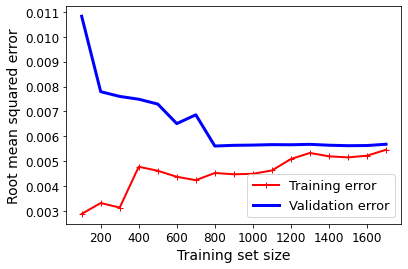

In [256]:
plot_learning_curves(nl_svm_all, dataset_prepared_stand, dataset_labels)

### Export model

In [250]:
ml_model = nl_svm_all.fit(dataset_prepared_stand, dataset_labels, sample_weight=weights)
feats = features
pipeline = transformation_pipeline

#### For ABM

In [251]:
import csv
from numpy import savetxt 

def export_model_for_abm(ml_model, feats, pipeline, folder_path):
    """
    ml_model already fitted
    """
    scaler = StandardScaler() # Needs to be instantiated to be passed to the ABM if not fit in its initialization
    dataset_only_transf = pipeline.fit_transform(dataset) ##
    scaler.fit(dataset_only_transf)
    model_for_abm = Pipeline([
        ("scaling", scaler),
        ("regressor", ml_model)
    ])
    joblib.dump(model_for_abm, os.path.join(folder_path, 'model.pkl'))
    # Check
    print(model_for_abm.predict(dataset_only_transf[0, :].reshape(1, -1))[0])
    
    #Export features name
    with open(os.path.join(folder_path, 'features.csv'), "w+") as file:
        wr = csv.writer(file)
        wr.writerow(feats)
    
    savetxt(os.path.join(folder_path, 'dataset.csv'), dataset_only_transf, delimiter=',')
    savetxt(os.path.join(folder_path, 'labels.csv'), dataset_labels.values,  delimiter=',') ##

In [252]:
folder_path = './Models for ABM/all_adoption/regressor'

In [253]:
export_model_for_abm(ml_model, feats, pipeline, folder_path)

0.0014178660461352886


#### For model analysis

In [254]:
joblib.dump(ml_model, './Models to analyse/all_adoption/regressor/nl_svm.pkl')

['./Models to analyse/all_adoption/regressor/nl_svm.pkl']